# Logistic Regression Model

## Data Import And Cleaning

In [40]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score, precision_score, confusion_matrix
from sklearn.metrics import roc_curve, auc
import scripts.logistic_regression_functions as lrf
import scripts.helper_functions as hf
from sklearn.preprocessing import StandardScaler

#reloads the module with the most recent updates
%load_ext autoreload
%aimport scripts.logistic_regression_functions, scripts.helper_functions
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [41]:
train_files = ['../../data/cleaned/utah_2017_vineyard.csv', 
               '../../data/cleaned/utah_2017_marina.csv']

test_files = [ '../../data/cleaned/utah_2018_marina.csv',
               '../../data/cleaned/utah_2018_bird.csv']

drop_columns = ['Chlorophyll ug/L', 'Chlorophyll RFU', 'Wiper Pos V',
                'Cable Pwr V', 'Battery V', 'Chlorophyll (ug/L)', 'FDOM RFU']

x_columns = ['Temp C', 'Sp Cond (uS/cm)', 'pH (mV)', 'pH', 'Turbidity (NTU)',
            'ODOSat%', 'ODO (mg/L)']

target_column = 'BGA-Phycocyanin RFU'

# TODO Create average off of minor bloom
RFU_THRESHOLD = 1.2
train_index = 0
test_index = 0

In [42]:
# Load the data
train_dfs = lrf.import_df_data(train_files, drop_columns)
test_dfs = lrf.import_df_data(test_files, drop_columns)

train_dfs[train_index].head()

,Date (mm.dd.yyyy),Time 24hr,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU
0,5/5/2017,0:00,15.02,1848,-100.1,8.36,16.84,90.2,9.04,0.4
1,5/5/2017,0:15,14.99,1847,-100.1,8.36,16.76,90.2,9.04,0.4
2,5/5/2017,0:30,14.96,1847,-100.1,8.36,16.82,90.1,9.04,0.4
3,5/5/2017,0:45,14.95,1848,-100.1,8.36,17.19,90.0,9.03,0.4
4,5/5/2017,1:00,14.92,1848,-100.0,8.36,16.85,89.8,9.02,0.4


## Use Datetime Index

In [43]:
print(test_dfs[test_index].dtypes)
print(train_dfs[train_index].dtypes)

Time America/Boise UTC-06:00     object
Temp C                          float64
Sp Cond (uS/cm)                   int64
pH (mV)                         float64
pH                              float64
Turbidity (NTU)                 float64
ODOSat%                         float64
ODO (mg/L)                      float64
BGA-Phycocyanin RFU             float64
dtype: object
Date (mm.dd.yyyy)       object
Time 24hr               object
Temp C                 float64
Sp Cond (uS/cm)          int64
pH (mV)                float64
pH                     float64
Turbidity (NTU)        float64
ODOSat%                float64
ODO (mg/L)             float64
BGA-Phycocyanin RFU    float64
dtype: object


In [44]:
# We will need to engineer a datetime column for our 2017 data

# Create a single datetime column from the strings provided in our csv's
for i in range(0, len(train_dfs)):
    timestamp = train_dfs[i]['Date (mm.dd.yyyy)'] + ' '+ train_dfs[i]['Time 24hr']
    timestamp = pd.to_datetime(timestamp)
    train_dfs[i]['timestamp'] = timestamp
    train_dfs[i]['datetime'] = timestamp
    train_dfs[i] = train_dfs[i].set_index('timestamp')
    train_dfs[i] = train_dfs[i].drop(columns=['Date (mm.dd.yyyy)', 'Time 24hr'])
train_dfs[train_index].head()

,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU,datetime
timestamp,,,,,,,,,
2017-05-05 00:00:00,15.02,1848,-100.1,8.36,16.84,90.2,9.04,0.4,2017-05-05 00:00:00
2017-05-05 00:15:00,14.99,1847,-100.1,8.36,16.76,90.2,9.04,0.4,2017-05-05 00:15:00
2017-05-05 00:30:00,14.96,1847,-100.1,8.36,16.82,90.1,9.04,0.4,2017-05-05 00:30:00
2017-05-05 00:45:00,14.95,1848,-100.1,8.36,17.19,90.0,9.03,0.4,2017-05-05 00:45:00
2017-05-05 01:00:00,14.92,1848,-100.0,8.36,16.85,89.8,9.02,0.4,2017-05-05 01:00:00


In [45]:
# Now to datetime index our 2018 data
for i in range(0, len(test_dfs)):
    timestamp = pd.to_datetime(test_dfs[i]['Time America/Boise UTC-06:00'])
    test_dfs[i]['timestamp'] = timestamp
    test_dfs[i]['datetime'] = timestamp
    test_dfs[i] = test_dfs[i].set_index('timestamp')
    test_dfs[i] = test_dfs[i].drop(columns=['Time America/Boise UTC-06:00'])
test_dfs[test_index].head()

,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU,datetime
timestamp,,,,,,,,,
2018-04-11 10:30:00,11.88,1782,-146.1,8.20,42.49,89.1,9.58,0.6,2018-04-11 10:30:00
2018-04-11 10:45:00,11.78,1783,-143.7,8.15,42.89,87.4,9.42,0.6,2018-04-11 10:45:00
2018-04-11 11:00:00,11.79,1784,-144.3,8.17,41.24,89.0,9.58,0.7,2018-04-11 11:00:00
2018-04-11 11:15:00,11.66,1783,-143.1,8.14,42.65,87.1,9.41,0.7,2018-04-11 11:15:00
2018-04-11 11:30:00,11.68,1784,-143.5,8.15,42.06,87.5,9.45,0.7,2018-04-11 11:30:00


## Import And Clean Weather Data

In [46]:
weather = pd.read_csv('../../data/cleaned/daily_weather_metric_2017_2018.csv')
weather.head()

,STATION,NAME,LATITUDE,LONGITUDE,ELEVATION,DATE,DAPR,EVAP,MDPR,MNPN,...,TMAX,TMIN,TOBS,WESD,WESF,WT01,WT03,WT04,WT05,WT11
0,USC00427064,"PROVO BYU, UT US",40.2458,-111.6508,1392.9,5/1/2017,NaN,NaN,NaN,NaN,...,18.9,7.2,13.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,USC00427064,"PROVO BYU, UT US",40.2458,-111.6508,1392.9,5/2/2017,NaN,NaN,NaN,NaN,...,19.4,7.8,17.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,USC00427064,"PROVO BYU, UT US",40.2458,-111.6508,1392.9,5/3/2017,NaN,NaN,NaN,NaN,...,21.7,4.4,21.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,USC00427064,"PROVO BYU, UT US",40.2458,-111.6508,1392.9,5/4/2017,NaN,NaN,NaN,NaN,...,26.7,6.7,26.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,USC00427064,"PROVO BYU, UT US",40.2458,-111.6508,1392.9,5/5/2017,NaN,NaN,NaN,NaN,...,31.7,8.9,30.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [47]:
# Find out how much of the data is missing for each column.
drop_columns = []
missing_threshold = .05
for column in weather.columns:
    number_null = np.sum(weather[column].isnull())
    column_length = len(weather[column])
    should_drop_column = (number_null / column_length) > missing_threshold
    print('{} percent null: {:.1f}%'.format(column, (number_null / column_length) * 100))
    if should_drop_column:
        drop_columns.append(column)
print('dropping columns: {}'.format(drop_columns))
weather = weather.drop(drop_columns, axis=1)

STATION percent null: 0.0%
NAME percent null: 0.0%
LATITUDE percent null: 0.0%
LONGITUDE percent null: 0.0%
ELEVATION percent null: 0.0%
DATE percent null: 0.0%
DAPR percent null: 99.7%
EVAP percent null: 50.6%
MDPR percent null: 99.7%
MNPN percent null: 50.9%
MXPN percent null: 50.9%
PRCP percent null: 0.9%
SNOW percent null: 0.5%
SNWD percent null: 0.5%
TAVG percent null: 100.0%
TMAX percent null: 0.2%
TMIN percent null: 0.0%
TOBS percent null: 0.5%
WESD percent null: 100.0%
WESF percent null: 100.0%
WT01 percent null: 100.0%
WT03 percent null: 99.5%
WT04 percent null: 100.0%
WT05 percent null: 100.0%
WT11 percent null: 100.0%
dropping columns: ['DAPR', 'EVAP', 'MDPR', 'MNPN', 'MXPN', 'TAVG', 'WESD', 'WESF', 'WT01', 'WT03', 'WT04', 'WT05', 'WT11']


In [48]:
# Drop the columns we will not be using.
weather = weather.drop(columns=['STATION','NAME','LATITUDE','LONGITUDE','ELEVATION', 'TOBS'])

In [49]:
weather['DATE'] = pd.to_datetime(weather['DATE'])
# Set a datetime index for convenience
weather['timestamp'] = weather['DATE']
weather = weather.set_index('timestamp')
weather.dtypes

DATE    datetime64[ns]
PRCP           float64
SNOW           float64
SNWD           float64
TMAX           float64
TMIN           float64
dtype: object

In [50]:
weather['DATE'] = weather['DATE'].apply(lambda x: x.date())

In [51]:
count = 0
total = len(train_dfs + test_dfs)
for df in train_dfs + test_dfs:
    count += 1
    print("starting dataframe {}/{}".format(count, total))
    for column in weather.drop(columns='DATE').columns:
        print("adding series for column:", column)
        values = []
        old_datetime = None
        value = None
        for datetime in df['datetime']:
            datetime = datetime.date()
            if datetime != old_datetime:
                old_datetime = datetime
                value = weather[weather['DATE'] == datetime][column]
            values.append(value.values[0] if len(value.values) > 0 else np.nan)
        df[column] = values

starting dataframe 1/4
adding series for column: PRCP
adding series for column: SNOW
adding series for column: SNWD
adding series for column: TMAX
adding series for column: TMIN
starting dataframe 2/4
adding series for column: PRCP
adding series for column: SNOW
adding series for column: SNWD
adding series for column: TMAX
adding series for column: TMIN
starting dataframe 3/4
adding series for column: PRCP
adding series for column: SNOW
adding series for column: SNWD
adding series for column: TMAX
adding series for column: TMIN
starting dataframe 4/4
adding series for column: PRCP
adding series for column: SNOW
adding series for column: SNWD
adding series for column: TMAX
adding series for column: TMIN


### Verify weather values copied over correctly

In [52]:
train_dfs[train_index].head(10)

,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU,datetime,PRCP,SNOW,SNWD,TMAX,TMIN
timestamp,,,,,,,,,,,,,,
2017-05-05 00:00:00,15.02,1848,-100.1,8.36,16.84,90.2,9.04,0.4,2017-05-05 00:00:00,0.0,0.0,0.0,31.7,8.9
2017-05-05 00:15:00,14.99,1847,-100.1,8.36,16.76,90.2,9.04,0.4,2017-05-05 00:15:00,0.0,0.0,0.0,31.7,8.9
2017-05-05 00:30:00,14.96,1847,-100.1,8.36,16.82,90.1,9.04,0.4,2017-05-05 00:30:00,0.0,0.0,0.0,31.7,8.9
2017-05-05 00:45:00,14.95,1848,-100.1,8.36,17.19,90.0,9.03,0.4,2017-05-05 00:45:00,0.0,0.0,0.0,31.7,8.9
2017-05-05 01:00:00,14.92,1848,-100.0,8.36,16.85,89.8,9.02,0.4,2017-05-05 01:00:00,0.0,0.0,0.0,31.7,8.9
2017-05-05 01:15:00,14.92,1850,-100.1,8.36,16.43,89.8,9.02,0.4,2017-05-05 01:15:00,0.0,0.0,0.0,31.7,8.9
2017-05-05 01:30:00,14.90,1851,-100.1,8.36,16.35,89.7,9.01,0.4,2017-05-05 01:30:00,0.0,0.0,0.0,31.7,8.9
2017-05-05 01:45:00,14.88,1852,-100.0,8.36,16.40,89.6,9.00,0.4,2017-05-05 01:45:00,0.0,0.0,0.0,31.7,8.9
2017-05-05 02:00:00,14.84,1850,-99.9,8.36,16.82,89.4,8.99,0.4,2017-05-05 02:00:00,0.0,0.0,0.0,31.7,8.9


In [53]:
weather.head(10)

,DATE,PRCP,SNOW,SNWD,TMAX,TMIN
timestamp,,,,,,
2017-05-01,2017-05-01,0.0,0.0,0.0,18.9,7.2
2017-05-02,2017-05-02,0.0,0.0,0.0,19.4,7.8
2017-05-03,2017-05-03,0.0,0.0,0.0,21.7,4.4
2017-05-04,2017-05-04,0.0,0.0,0.0,26.7,6.7
2017-05-05,2017-05-05,0.0,0.0,0.0,31.7,8.9
2017-05-06,2017-05-06,1.8,0.0,0.0,30.6,15.0
2017-05-07,2017-05-07,0.0,0.0,0.0,27.2,18.9
2017-05-08,2017-05-08,0.0,0.0,0.0,25.6,12.2
2017-05-09,2017-05-09,0.0,0.0,0.0,25.6,9.4


### Import and Clean Wind Data

In [54]:
weather_files = ['../../data/raw_data/weather/provo_airport_2017', '../../data/raw_data/weather/provo_airport_2018']
# the array to store the readings in
contents = []

# Extract the weather data in the ISD format
for file in weather_files:
    contents.append(hf.extract_weather_data(file))


In [55]:
# the dfs containing the wind information for the readings.
wind_frame_2017 = pd.DataFrame(columns=["angle","speed"])
wind_frame_2018 = pd.DataFrame(columns=["angle","speed"])


wind_frames = [wind_frame_2017, wind_frame_2018]
for i in range(len(contents)):
    wind_dict = {}
    for reading in contents[i]:
        reading.GPO_timestamp = hf.round_time(reading.GPO_timestamp)

        # no key value made yet
        if reading.GPO_timestamp not in wind_dict.keys():
            # check to see if the readings are valid
            # Sets them to 'invalid' so that when we inpute them it can be handled
            if reading.WO_wind_angle == '999':
                reading.WO_wind_angle = np.nan
            else:
                reading.WO_wind_angle = int(reading.WO_wind_angle)
            if reading.WO_wind_speed == '9999':
                reading.WO_wind_speed = np.nan
            else:
                reading.WO_wind_speed = int(reading.WO_wind_speed)
            wind_dict[reading.GPO_timestamp] = [reading.WO_wind_angle, reading.WO_wind_speed]
    wind_frames[i] = pd.DataFrame.from_dict(wind_dict, orient='index')
    wind_frames[i] = wind_frames[i].rename(columns={0:'Wind Angle', 1:'Wind Speed'})

In [56]:
#we need to join the wind data now to the existing dataframes, but the dont care about

for i in range(len(train_dfs)):
    # train dfs is the 2017 data set so we need to set the wind frame to that 
    # dataset
    train_dfs[i] = train_dfs[i].join(wind_frames[0])
for i in range(len(test_dfs)):
    # test dfs is the 2018 data set so we need to set the wind frame to that
    # dataset
    test_dfs[i] = test_dfs[i].join(wind_frames[1])

In [57]:
train_dfs[train_index].head(5)

,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU,datetime,PRCP,SNOW,SNWD,TMAX,TMIN,Wind Angle,Wind Speed
timestamp,,,,,,,,,,,,,,,,
2017-05-05 00:00:00,15.02,1848,-100.1,8.36,16.84,90.2,9.04,0.4,2017-05-05 00:00:00,0.0,0.0,0.0,31.7,8.9,250.0,26.0
2017-05-05 00:15:00,14.99,1847,-100.1,8.36,16.76,90.2,9.04,0.4,2017-05-05 00:15:00,0.0,0.0,0.0,31.7,8.9,NaN,NaN
2017-05-05 00:30:00,14.96,1847,-100.1,8.36,16.82,90.1,9.04,0.4,2017-05-05 00:30:00,0.0,0.0,0.0,31.7,8.9,NaN,NaN
2017-05-05 00:45:00,14.95,1848,-100.1,8.36,17.19,90.0,9.03,0.4,2017-05-05 00:45:00,0.0,0.0,0.0,31.7,8.9,NaN,NaN
2017-05-05 01:00:00,14.92,1848,-100.0,8.36,16.85,89.8,9.02,0.4,2017-05-05 01:00:00,0.0,0.0,0.0,31.7,8.9,240.0,26.0


In [58]:
test_dfs[test_index].head(5)

,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU,datetime,PRCP,SNOW,SNWD,TMAX,TMIN,Wind Angle,Wind Speed
timestamp,,,,,,,,,,,,,,,,
2018-04-11 10:30:00,11.88,1782,-146.1,8.20,42.49,89.1,9.58,0.6,2018-04-11 10:30:00,0.0,0.0,0.0,25.0,10.0,NaN,NaN
2018-04-11 10:45:00,11.78,1783,-143.7,8.15,42.89,87.4,9.42,0.6,2018-04-11 10:45:00,0.0,0.0,0.0,25.0,10.0,NaN,NaN
2018-04-11 11:00:00,11.79,1784,-144.3,8.17,41.24,89.0,9.58,0.7,2018-04-11 11:00:00,0.0,0.0,0.0,25.0,10.0,300.0,62.0
2018-04-11 11:15:00,11.66,1783,-143.1,8.14,42.65,87.1,9.41,0.7,2018-04-11 11:15:00,0.0,0.0,0.0,25.0,10.0,NaN,NaN
2018-04-11 11:30:00,11.68,1784,-143.5,8.15,42.06,87.5,9.45,0.7,2018-04-11 11:30:00,0.0,0.0,0.0,25.0,10.0,NaN,NaN


Need to deal with the NaNs in the dataframe for the WInd Angle and Wind Speed. There is a couple of ways that we can do this. One way is to assume that the wind doesn't change direction from the last valid responce (or the next in the case where the first entry is a NaN) or to assume that weather acts predictibly and will change direction and angle easily from entry to entry. 

I.E first entry 120 angle and 36 m/s speed, second (valid) entry 160 angle and 24 m/s speed slowing pan the angle inbetween and decrese the speed throughout so the entrries would look something like this:

From:

|Time Stamp|angle | speed |
|--|--|--|
|2018-04-11 12:00:00|120|36|
|2018-04-11 12:15:00|NaN|NaN|
|2018-04-11 12:30:00|NaN|NaN|
|2018-04-11 12:45:00|NaN|NaN|
|2018-04-11 13:00:00|160|24|

To:

|Time Stamp|angle | speed |
|--|--|--|
|2018-04-11 12:00:00|120|36|
|2018-04-11 12:15:00|130|33 |
|2018-04-11 12:30:00|140|30 |
|2018-04-11 12:45:00|150|27 |
|2018-04-11 13:00:00|160|24 |

In [59]:
for i in range(len(train_dfs)):
    train_dfs[i]['Wind Angle'] = train_dfs[i]['Wind Angle'].interpolate(limit_direction='both')
    train_dfs[i]['Wind Speed'] = train_dfs[i]['Wind Speed'].interpolate(limit_direction='both')
for i in range(len(test_dfs)):
    #test dfs is the 2018 data set so we need to set the wind frame to that dataset
    test_dfs[i]['Wind Angle'] = test_dfs[i]['Wind Angle'].interpolate(limit_direction='both')
    test_dfs[i]['Wind Speed'] = test_dfs[i]['Wind Speed'].interpolate(limit_direction='both')

In [60]:
train_dfs[train_index].head(5)

,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU,datetime,PRCP,SNOW,SNWD,TMAX,TMIN,Wind Angle,Wind Speed
timestamp,,,,,,,,,,,,,,,,
2017-05-05 00:00:00,15.02,1848,-100.1,8.36,16.84,90.2,9.04,0.4,2017-05-05 00:00:00,0.0,0.0,0.0,31.7,8.9,250.0,26.0
2017-05-05 00:15:00,14.99,1847,-100.1,8.36,16.76,90.2,9.04,0.4,2017-05-05 00:15:00,0.0,0.0,0.0,31.7,8.9,247.5,26.0
2017-05-05 00:30:00,14.96,1847,-100.1,8.36,16.82,90.1,9.04,0.4,2017-05-05 00:30:00,0.0,0.0,0.0,31.7,8.9,245.0,26.0
2017-05-05 00:45:00,14.95,1848,-100.1,8.36,17.19,90.0,9.03,0.4,2017-05-05 00:45:00,0.0,0.0,0.0,31.7,8.9,242.5,26.0
2017-05-05 01:00:00,14.92,1848,-100.0,8.36,16.85,89.8,9.02,0.4,2017-05-05 01:00:00,0.0,0.0,0.0,31.7,8.9,240.0,26.0


In [61]:
test_dfs[test_index].head(5)

,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU,datetime,PRCP,SNOW,SNWD,TMAX,TMIN,Wind Angle,Wind Speed
timestamp,,,,,,,,,,,,,,,,
2018-04-11 10:30:00,11.88,1782,-146.1,8.20,42.49,89.1,9.58,0.6,2018-04-11 10:30:00,0.0,0.0,0.0,25.0,10.0,300.0,62.0
2018-04-11 10:45:00,11.78,1783,-143.7,8.15,42.89,87.4,9.42,0.6,2018-04-11 10:45:00,0.0,0.0,0.0,25.0,10.0,300.0,62.0
2018-04-11 11:00:00,11.79,1784,-144.3,8.17,41.24,89.0,9.58,0.7,2018-04-11 11:00:00,0.0,0.0,0.0,25.0,10.0,300.0,62.0
2018-04-11 11:15:00,11.66,1783,-143.1,8.14,42.65,87.1,9.41,0.7,2018-04-11 11:15:00,0.0,0.0,0.0,25.0,10.0,255.0,55.5
2018-04-11 11:30:00,11.68,1784,-143.5,8.15,42.06,87.5,9.45,0.7,2018-04-11 11:30:00,0.0,0.0,0.0,25.0,10.0,210.0,49.0


## Optimal Window Size For Individual Features

In [81]:
# add the weather columns to our x_columns
x_columns = list(set(x_columns + 
                     ['PRCP', 'SNOW', 'SNWD', 'TMAX', 'TMIN', 
                      'rainy', 'Wind Speed', 'Wind Angle']))

iteration_delta = pd.Timedelta(1, unit='d')
max_x_window = pd.Timedelta(30, unit='d') 
current_y_window = pd.Timedelta(1, unit='d')
best_accuracy = 0
best_recall = 0
best_precision = 0
best_x_window = iteration_delta
best_y_window = current_y_window
accuracies = dict()
window_sizes = []

max_iter = 25000
loss = "log"

current_x_window = current_y_window
while current_x_window <= max_x_window:
    
    # Windowize
    print("current x window", current_x_window)
    print("Windowizing 2017 data set:", train_index)
    train = hf.data_window_reduction(
        train_dfs[train_index], 'datetime', target_column, 
        x_win_size=current_x_window, y_win_size=current_y_window)
    print("Windowizing 2018 data set:", test_index)
    test = hf.data_window_reduction(
        test_dfs[test_index], 'datetime', target_column,
        x_win_size=current_x_window, y_win_size=current_y_window)
    print()

    #Add rainy column
    for df in [test, train]:
        df['rainy'] = df['PRCP'].apply(
            lambda x: 1 if x > 0 else 0).astype('category')

    #Add target columns
    lrf.add_target_column([train, test], threshold=RFU_THRESHOLD)
    window_sizes.append(current_x_window)
    
    for col in x_columns:
        # Create model
        print("Training model on:", col)
        model = SGDClassifier(max_iter=max_iter, loss=loss)
        accuracy, recall, precision, cm, predictions, _, _ = lrf.train_model(
            model, train, test, [col],'bloom')
        print("accuracy", accuracy)
        print("recall", recall)
        print("precision", precision)
        print()
        if col not in accuracies:
            accuracies[col] = []
        accuracies[col].append(accuracy)
    current_x_window += iteration_delta

current x window 1 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.42318840579710143
recall 0.0
precision 0.0

Training model on: ODO (mg/L)
accuracy 0.672463768115942
recall 0.6331658291457286
precision 0.7590361445783133

Training model on: pH
accuracy 0.6695652173913044
recall 0.9045226130653267
precision 0.6545454545454545

Training model on: pH (mV)
accuracy 0.5768115942028985
recall 1.0
precision 0.5768115942028985

Training model on: Wind Angle
accuracy 0.47246376811594204
recall 0.19597989949748743
precision 0.639344262295082

Training model on: Temp C
accuracy 0.5942028985507246
recall 0.4271356783919598
precision 0.7657657657657657

Training model on: TMAX
accuracy 0.591304347826087
recall 0.5025125628140703
precision 0.704225352112676

Training model on: PRCP


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.42318840579710143
recall 0.0
precision 0.0

Training model on: TMIN
accuracy 0.6463768115942029
recall 0.4824120603015075
precision 0.8347826086956521

Training model on: rainy


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.42318840579710143
recall 0.0
precision 0.0

Training model on: Wind Speed
accuracy 0.4405797101449275
recall 0.09045226130653267
precision 0.6

Training model on: Turbidity (NTU)


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.42318840579710143
recall 0.0
precision 0.0

Training model on: Sp Cond (uS/cm)


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.42318840579710143
recall 0.0
precision 0.0

Training model on: ODOSat%
accuracy 0.7101449275362319
recall 0.6683417085427136
precision 0.7964071856287425

Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.42318840579710143
recall 0.0
precision 0.0

current x window 2 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4198250728862974
recall 0.0
precision 0.0

Training model on: ODO (mg/L)
accuracy 0.717201166180758
recall 0.7185929648241206
precision 0.7771739130434783

Training model on: pH
accuracy 0.6909620991253644
recall 0.9195979899497487
precision 0.6703296703296703

Training model on: pH (mV)
accuracy 0.5801749271137027
recall 1.0
precision 0.5801749271137027

Training model on: Wind Angle
accuracy 0.4752186588921283
recall 0.21105527638190955
precision 0.6461538461538462

Training model on: Temp C
accuracy 0.6151603498542274
recall 0.45226130653266333
precision 0.7964601769911505

Training model on: TMAX
accuracy 0.6005830903790087
recall 0.5125628140703518
precision 0.7183098591549296

Training model on: PRCP


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4198250728862974
recall 0.0
precision 0.0

Training model on: TMIN
accuracy 0.6880466472303207
recall 0.5628140703517588
precision 0.8484848484848485

Training model on: rainy


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4198250728862974
recall 0.0
precision 0.0

Training model on: Wind Speed
accuracy 0.5276967930029155
recall 0.36180904522613067
precision 0.6728971962616822

Training model on: Turbidity (NTU)


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4198250728862974
recall 0.0
precision 0.0

Training model on: Sp Cond (uS/cm)


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4198250728862974
recall 0.0
precision 0.0

Training model on: ODOSat%
accuracy 0.7288629737609329
recall 0.7085427135678392
precision 0.8011363636363636

Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4198250728862974
recall 0.0
precision 0.0

current x window 3 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.41228070175438597
recall 0.0
precision 0.0

Training model on: ODO (mg/L)
accuracy 0.7280701754385965
recall 0.7313432835820896
precision 0.7903225806451613

Training model on: pH
accuracy 0.6929824561403509
recall 0.9253731343283582
precision 0.6739130434782609

Training model on: pH (mV)
accuracy 0.5877192982456141
recall 1.0
precision 0.5877192982456141

Training model on: Wind Angle
accuracy 0.4590643274853801
recall 0.208955223880597
precision 0.6176470588235294

Training model on: Temp C
accuracy 0.5877192982456141
recall 0.373134328358209
precision 0.8333333333333334

Training model on: TMAX
accuracy 0.5321637426900585
recall 0.4129353233830846
precision 0.664

Training model on: PRCP


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.41228070175438597
recall 0.0
precision 0.0

Training model on: TMIN
accuracy 0.6666666666666666
recall 0.5373134328358209
precision 0.8372093023255814

Training model on: rainy


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.41228070175438597
recall 0.0
precision 0.0

Training model on: Wind Speed
accuracy 0.5
recall 0.24875621890547264
precision 0.7142857142857143

Training model on: Turbidity (NTU)


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.41228070175438597
recall 0.0
precision 0.0

Training model on: Sp Cond (uS/cm)


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.41228070175438597
recall 0.0
precision 0.0

Training model on: ODOSat%
accuracy 0.7485380116959064
recall 0.7114427860696517
precision 0.8362573099415205

Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.41228070175438597
recall 0.0
precision 0.0

current x window 4 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4147058823529412
recall 0.0
precision 0.0

Training model on: ODO (mg/L)
accuracy 0.7676470588235295
recall 0.7839195979899497
precision 0.8125

Training model on: pH
accuracy 0.6735294117647059
recall 0.9195979899497487
precision 0.658273381294964

Training model on: pH (mV)
accuracy 0.5852941176470589
recall 1.0
precision 0.5852941176470589

Training model on: Wind Angle
accuracy 0.5029411764705882
recall 0.2914572864321608
precision 0.6744186046511628

Training model on: Temp C
accuracy 0.6176470588235294
recall 0.457286432160804
precision 0.8053097345132744

Training model on: TMAX
accuracy 0.5852941176470589
recall 0.5175879396984925
precision 0.6959459459459459

Training model on: PRCP


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4147058823529412
recall 0.0
precision 0.0

Training model on: TMIN
accuracy 0.6852941176470588
recall 0.5879396984924623
precision 0.823943661971831

Training model on: rainy


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4147058823529412
recall 0.0
precision 0.0

Training model on: Wind Speed
accuracy 0.5735294117647058
recall 0.3768844221105528
precision 0.78125

Training model on: Turbidity (NTU)


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4147058823529412
recall 0.0
precision 0.0

Training model on: Sp Cond (uS/cm)


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4147058823529412
recall 0.0
precision 0.0

Training model on: ODOSat%
accuracy 0.75
recall 0.7286432160804021
precision 0.8238636363636364

Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4147058823529412
recall 0.0
precision 0.0

current x window 5 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4171597633136095
recall 0.0
precision 0.0

Training model on: ODO (mg/L)
accuracy 0.7869822485207101
recall 0.817258883248731
precision 0.817258883248731

Training model on: pH
accuracy 0.6627218934911243
recall 0.9238578680203046
precision 0.6476868327402135

Training model on: pH (mV)
accuracy 0.5828402366863905
recall 1.0
precision 0.5828402366863905

Training model on: Wind Angle
accuracy 0.4940828402366864
recall 0.25888324873096447
precision 0.6710526315789473

Training model on: Temp C
accuracy 0.6242603550295858
recall 0.49746192893401014
precision 0.7777777777777778

Training model on: TMAX
accuracy 0.5887573964497042
recall 0.5380710659898477
precision 0.6883116883116883

Training model on: PRCP


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4171597633136095
recall 0.0
precision 0.0

Training model on: TMIN
accuracy 0.6923076923076923
recall 0.6142131979695431
precision 0.8120805369127517

Training model on: rainy


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4171597633136095
recall 0.0
precision 0.0

Training model on: Wind Speed
accuracy 0.5857988165680473
recall 0.467005076142132
precision 0.7244094488188977

Training model on: Turbidity (NTU)
accuracy 0.4230769230769231
recall 0.06091370558375635
precision 0.5454545454545454

Training model on: Sp Cond (uS/cm)
accuracy 0.41420118343195267
recall 0.005076142131979695
precision 0.3333333333333333

Training model on: ODOSat%
accuracy 0.7544378698224852
recall 0.751269035532995
precision 0.8131868131868132

Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4171597633136095
recall 0.0
precision 0.0

current x window 6 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.41543026706231456
recall 0.0
precision 0.0

Training model on: ODO (mg/L)
accuracy 0.7922848664688428
recall 0.8324873096446701
precision 0.8159203980099502

Training model on: pH
accuracy 0.6884272997032641
recall 0.9390862944162437
precision 0.6654676258992805

Training model on: pH (mV)
accuracy 0.5845697329376854
recall 1.0
precision 0.5845697329376854

Training model on: Wind Angle
accuracy 0.49851632047477745
recall 0.23857868020304568
precision 0.7121212121212122

Training model on: Temp C
accuracy 0.6142433234421365
recall 0.40609137055837563
precision 0.8602150537634409

Training model on: TMAX
accuracy 0.5578635014836796
recall 0.48223350253807107
precision 0.6690140845070423

Training model on: PRCP


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.41543026706231456
recall 0.0
precision 0.0

Training model on: TMIN
accuracy 0.6646884272997032
recall 0.5228426395939086
precision 0.8442622950819673

Training model on: rainy


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.41543026706231456
recall 0.0
precision 0.0

Training model on: Wind Speed
accuracy 0.5875370919881305
recall 0.4467005076142132
precision 0.7457627118644068

Training model on: Turbidity (NTU)
accuracy 0.43026706231454004
recall 0.05583756345177665
precision 0.6470588235294118

Training model on: Sp Cond (uS/cm)


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.41543026706231456
recall 0.0
precision 0.0

Training model on: ODOSat%
accuracy 0.7922848664688428
recall 0.7461928934010152
precision 0.8802395209580839

Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.41543026706231456
recall 0.0
precision 0.0

current x window 7 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4059701492537313
recall 0.0
precision 0.0

Training model on: ODO (mg/L)
accuracy 0.7970149253731343
recall 0.8391959798994975
precision 0.8226600985221675

Training model on: pH
accuracy 0.6835820895522388
recall 0.9396984924623115
precision 0.6654804270462633

Training model on: pH (mV)
accuracy 0.5940298507462687
recall 1.0
precision 0.5940298507462687

Training model on: Wind Angle
accuracy 0.49850746268656715
recall 0.22613065326633167
precision 0.7627118644067796

Training model on: Temp C
accuracy 0.6179104477611941
recall 0.4120603015075377
precision 0.8817204301075269

Training model on: TMAX
accuracy 0.564179104477612
recall 0.40703517587939697
precision 0.7431192660550459

Training model on: PRCP


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4059701492537313
recall 0.0
precision 0.0

Training model on: TMIN
accuracy 0.6716417910447762
recall 0.5376884422110553
precision 0.856

Training model on: rainy


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4059701492537313
recall 0.0
precision 0.0

Training model on: Wind Speed
accuracy 0.6029850746268657
recall 0.4321608040201005
precision 0.8113207547169812

Training model on: Turbidity (NTU)
accuracy 0.44776119402985076
recall 0.11055276381909548
precision 0.7333333333333333

Training model on: Sp Cond (uS/cm)
accuracy 0.39104477611940297
recall 0.010050251256281407
precision 0.2222222222222222

Training model on: ODOSat%
accuracy 0.8029850746268656
recall 0.7587939698492462
precision 0.893491124260355

Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4059701492537313
recall 0.0
precision 0.0

current x window 8 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4174174174174174
recall 0.0
precision 0.0

Training model on: ODO (mg/L)
accuracy 0.8048048048048048
recall 0.8711340206185567
precision 0.8086124401913876

Training model on: pH
accuracy 0.6546546546546547
recall 0.9381443298969072
precision 0.6385964912280702

Training model on: pH (mV)
accuracy 0.5825825825825826
recall 1.0
precision 0.5825825825825826

Training model on: Wind Angle
accuracy 0.4924924924924925
recall 0.15979381443298968
precision 0.8378378378378378

Training model on: Temp C
accuracy 0.6096096096096096
recall 0.4742268041237113
precision 0.7666666666666667

Training model on: TMAX
accuracy 0.5675675675675675
recall 0.5103092783505154
precision 0.668918918918919

Training model on: PRCP


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4174174174174174
recall 0.0
precision 0.0

Training model on: TMIN
accuracy 0.7327327327327328
recall 0.7010309278350515
precision 0.8143712574850299

Training model on: rainy


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4174174174174174
recall 0.0
precision 0.0

Training model on: Wind Speed
accuracy 0.5975975975975976
recall 0.4484536082474227
precision 0.7631578947368421

Training model on: Turbidity (NTU)
accuracy 0.45645645645645644
recall 0.30927835051546393
precision 0.5607476635514018

Training model on: Sp Cond (uS/cm)
accuracy 0.3843843843843844
recall 0.02577319587628866
precision 0.23809523809523808

Training model on: ODOSat%
accuracy 0.7957957957957958
recall 0.7525773195876289
precision 0.8795180722891566

Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4174174174174174
recall 0.0
precision 0.0

current x window 9 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4108761329305136
recall 0.0
precision 0.0

Training model on: ODO (mg/L)
accuracy 0.8157099697885196
recall 0.882051282051282
precision 0.819047619047619

Training model on: pH
accuracy 0.6555891238670695
recall 0.9435897435897436
precision 0.6411149825783972

Training model on: pH (mV)
accuracy 0.5891238670694864
recall 1.0
precision 0.5891238670694864

Training model on: Wind Angle
accuracy 0.48942598187311176
recall 0.15897435897435896
precision 0.8611111111111112

Training model on: Temp C
accuracy 0.6102719033232629
recall 0.48205128205128206
precision 0.7704918032786885

Training model on: TMAX
accuracy 0.5921450151057401
recall 0.5384615384615384
precision 0.7

Training model on: PRCP


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4108761329305136
recall 0.0
precision 0.0

Training model on: TMIN
accuracy 0.7522658610271903
recall 0.7282051282051282
precision 0.8304093567251462

Training model on: rainy


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4108761329305136
recall 0.0
precision 0.0

Training model on: Wind Speed
accuracy 0.595166163141994
recall 0.4564102564102564
precision 0.7606837606837606

Training model on: Turbidity (NTU)
accuracy 0.4561933534743202
recall 0.40512820512820513
precision 0.5524475524475524

Training model on: Sp Cond (uS/cm)
accuracy 0.3564954682779456
recall 0.020512820512820513
precision 0.15384615384615385

Training model on: ODOSat%
accuracy 0.8126888217522659
recall 0.7692307692307693
precision 0.8982035928143712

Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4108761329305136
recall 0.0
precision 0.0

current x window 10 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4
recall 0.0
precision 0.0

Training model on: ODO (mg/L)
accuracy 0.8303030303030303
recall 0.8838383838383839
precision 0.8413461538461539

Training model on: pH
accuracy 0.6666666666666666
recall 0.9494949494949495
precision 0.6527777777777778

Training model on: pH (mV)
accuracy 0.6
recall 1.0
precision 0.6

Training model on: Wind Angle
accuracy 0.48787878787878786
recall 0.1717171717171717
precision 0.8717948717948718

Training model on: Temp C
accuracy 0.6333333333333333
recall 0.41414141414141414
precision 0.9425287356321839

Training model on: TMAX
accuracy 0.5636363636363636
recall 0.4292929292929293
precision 0.7327586206896551

Training model on: PRCP


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4
recall 0.0
precision 0.0

Training model on: TMIN
accuracy 0.6878787878787879
recall 0.5757575757575758
precision 0.8571428571428571

Training model on: rainy


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4
recall 0.0
precision 0.0

Training model on: Wind Speed
accuracy 0.6333333333333333
recall 0.4595959595959596
precision 0.8666666666666667

Training model on: Turbidity (NTU)
accuracy 0.5060606060606061
recall 0.3686868686868687
precision 0.6576576576576577

Training model on: Sp Cond (uS/cm)
accuracy 0.34545454545454546
recall 0.020202020202020204
precision 0.15384615384615385

Training model on: ODOSat%
accuracy 0.8
recall 0.7525252525252525
precision 0.8975903614457831

Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4
recall 0.0
precision 0.0

current x window 11 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4115853658536585
recall 0.0
precision 0.0

Training model on: ODO (mg/L)
accuracy 0.8262195121951219
recall 0.9067357512953368
precision 0.8177570093457944

Training model on: pH
accuracy 0.6432926829268293
recall 0.9533678756476683
precision 0.6301369863013698

Training model on: pH (mV)
accuracy 0.5884146341463414
recall 1.0
precision 0.5884146341463414

Training model on: Wind Angle
accuracy 0.49085365853658536
recall 0.16062176165803108
precision 0.8611111111111112

Training model on: Temp C
accuracy 0.6646341463414634
recall 0.49222797927461137
precision 0.8878504672897196

Training model on: TMAX
accuracy 0.5914634146341463
recall 0.46632124352331605
precision 0.743801652892562

Training model on: PRCP


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4115853658536585
recall 0.0
precision 0.0

Training model on: TMIN
accuracy 0.6951219512195121
recall 0.5958549222797928
precision 0.8394160583941606

Training model on: rainy


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4115853658536585
recall 0.0
precision 0.0

Training model on: Wind Speed
accuracy 0.6737804878048781
recall 0.5854922279792746
precision 0.8071428571428572

Training model on: Turbidity (NTU)
accuracy 0.5304878048780488
recall 0.49740932642487046
precision 0.6274509803921569

Training model on: Sp Cond (uS/cm)
accuracy 0.23780487804878048
recall 0.025906735751295335
precision 0.07462686567164178

Training model on: ODOSat%
accuracy 0.8170731707317073
recall 0.7875647668393783
precision 0.8888888888888888

Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4115853658536585
recall 0.0
precision 0.0

current x window 12 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4171779141104294
recall 0.0
precision 0.0

Training model on: ODO (mg/L)
accuracy 0.8343558282208589
recall 0.8842105263157894
precision 0.84

Training model on: pH
accuracy 0.6319018404907976
recall 0.9578947368421052
precision 0.6190476190476191

Training model on: pH (mV)
accuracy 0.5828220858895705
recall 1.0
precision 0.5828220858895705

Training model on: Wind Angle
accuracy 0.4815950920245399
recall 0.13157894736842105
precision 0.8620689655172413

Training model on: Temp C
accuracy 0.6196319018404908
recall 0.5052631578947369
precision 0.7619047619047619

Training model on: TMAX
accuracy 0.6073619631901841
recall 0.5842105263157895
precision 0.69375

Training model on: PRCP


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4171779141104294
recall 0.0
precision 0.0

Training model on: TMIN
accuracy 0.6932515337423313
recall 0.6052631578947368
precision 0.8214285714285714

Training model on: rainy


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4171779141104294
recall 0.0
precision 0.0

Training model on: Wind Speed
accuracy 0.656441717791411
recall 0.5736842105263158
precision 0.7785714285714286

Training model on: Turbidity (NTU)
accuracy 0.5245398773006135
recall 0.5684210526315789
precision 0.5966850828729282

Training model on: Sp Cond (uS/cm)
accuracy 0.22699386503067484
recall 0.06315789473684211
precision 0.13953488372093023

Training model on: ODOSat%
accuracy 0.8220858895705522
recall 0.8
precision 0.8837209302325582

Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4171779141104294
recall 0.0
precision 0.0

current x window 13 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4153846153846154
recall 0.0
precision 0.0

Training model on: ODO (mg/L)
accuracy 0.8246153846153846
recall 0.8789473684210526
precision 0.8308457711442786

Training model on: pH
accuracy 0.6461538461538462
recall 0.9736842105263158
precision 0.6271186440677966

Training model on: pH (mV)
accuracy 0.5846153846153846
recall 1.0
precision 0.5846153846153846

Training model on: Wind Angle
accuracy 0.4553846153846154
recall 0.08421052631578947
precision 0.8421052631578947

Training model on: Temp C
accuracy 0.6523076923076923
recall 0.4368421052631579
precision 0.9325842696629213

Training model on: TMAX
accuracy 0.6061538461538462
recall 0.48947368421052634
precision 0.75

Training model on: PRCP


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4153846153846154
recall 0.0
precision 0.0

Training model on: TMIN
accuracy 0.6984615384615385
recall 0.6157894736842106
precision 0.823943661971831

Training model on: rainy


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4153846153846154
recall 0.0
precision 0.0

Training model on: Wind Speed
accuracy 0.6492307692307693
recall 0.5105263157894737
precision 0.8220338983050848

Training model on: Turbidity (NTU)
accuracy 0.48
recall 0.4473684210526316
precision 0.5704697986577181

Training model on: Sp Cond (uS/cm)
accuracy 0.23076923076923078
recall 0.021052631578947368
precision 0.058823529411764705

Training model on: ODOSat%
accuracy 0.8369230769230769
recall 0.8157894736842105
precision 0.8959537572254336

Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4153846153846154
recall 0.0
precision 0.0

current x window 14 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4024767801857585
recall 0.0
precision 0.0

Training model on: ODO (mg/L)
accuracy 0.8359133126934984
recall 0.8860103626943006
precision 0.8465346534653465

Training model on: pH
accuracy 0.6470588235294118
recall 0.9689119170984456
precision 0.6338983050847458

Training model on: pH (mV)
accuracy 0.5975232198142415
recall 1.0
precision 0.5975232198142415

Training model on: Wind Angle
accuracy 0.42724458204334365
recall 0.05181347150259067
precision 0.8333333333333334

Training model on: Temp C
accuracy 0.653250773993808
recall 0.44559585492227977
precision 0.945054945054945

Training model on: TMAX
accuracy 0.6006191950464397
recall 0.49222797927461137
precision 0.753968253968254

Training model on: PRCP


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4024767801857585
recall 0.0
precision 0.0

Training model on: TMIN
accuracy 0.6996904024767802
recall 0.6269430051813472
precision 0.8287671232876712

Training model on: rainy


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4024767801857585
recall 0.0
precision 0.0

Training model on: Wind Speed
accuracy 0.6904024767801857
recall 0.5854922279792746
precision 0.849624060150376

Training model on: Turbidity (NTU)
accuracy 0.5108359133126935
recall 0.5077720207253886
precision 0.6086956521739131

Training model on: Sp Cond (uS/cm)
accuracy 0.21671826625386997
recall 0.05699481865284974
precision 0.13414634146341464

Training model on: ODOSat%
accuracy 0.8328173374613003
recall 0.8134715025906736
precision 0.8971428571428571

Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4024767801857585
recall 0.0
precision 0.0

current x window 15 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4236760124610592
recall 0.0
precision 0.0

Training model on: ODO (mg/L)
accuracy 0.822429906542056
recall 0.8972972972972973
precision 0.8137254901960784

Training model on: pH
accuracy 0.6261682242990654
recall 0.9837837837837838
precision 0.6086956521739131

Training model on: pH (mV)
accuracy 0.5763239875389408
recall 1.0
precision 0.5763239875389408

Training model on: Wind Angle
accuracy 0.43613707165109034
recall 0.02702702702702703
precision 0.8333333333333334

Training model on: Temp C
accuracy 0.7009345794392523
recall 0.518918918918919
precision 0.9320388349514563

Training model on: TMAX
accuracy 0.6230529595015576
recall 0.5243243243243243
precision 0.7461538461538462

Training model on: PRCP


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4236760124610592
recall 0.0
precision 0.0

Training model on: TMIN
accuracy 0.7258566978193146
recall 0.6648648648648648
precision 0.825503355704698

Training model on: rainy
accuracy 0.4766355140186916
recall 0.2648648648648649
precision 0.6049382716049383

Training model on: Wind Speed
accuracy 0.6884735202492211
recall 0.6108108108108108
precision 0.8014184397163121

Training model on: Turbidity (NTU)
accuracy 0.5295950155763239
recall 0.5837837837837838
precision 0.5934065934065934

Training model on: Sp Cond (uS/cm)
accuracy 0.2118380062305296
recall 0.043243243243243246
precision 0.09523809523809523

Training model on: ODOSat%
accuracy 0.8473520249221184
recall 0.8432432432432433
precision 0.8863636363636364

Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4236760124610592
recall 0.0
precision 0.0

current x window 16 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4169278996865204
recall 0.0
precision 0.0

Training model on: ODO (mg/L)
accuracy 0.8181818181818182
recall 0.8924731182795699
precision 0.8137254901960784

Training model on: pH
accuracy 0.6332288401253918
recall 0.989247311827957
precision 0.6153846153846154

Training model on: pH (mV)
accuracy 0.5830721003134797
recall 1.0
precision 0.5830721003134797

Training model on: Wind Angle
accuracy 0.42946708463949845
recall 0.021505376344086023
precision 1.0

Training model on: Temp C
accuracy 0.7084639498432602
recall 0.532258064516129
precision 0.9428571428571428

Training model on: TMAX
accuracy 0.64576802507837
recall 0.5483870967741935
precision 0.7786259541984732

Training model on: PRCP


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4169278996865204
recall 0.0
precision 0.0

Training model on: TMIN
accuracy 0.7429467084639498
recall 0.6881720430107527
precision 0.8421052631578947

Training model on: rainy
accuracy 0.48589341692789967
recall 0.25806451612903225
precision 0.6486486486486487

Training model on: Wind Speed
accuracy 0.6394984326018809
recall 0.6129032258064516
precision 0.7261146496815286

Training model on: Turbidity (NTU)
accuracy 0.4608150470219436
recall 0.553763440860215
precision 0.5364583333333334

Training model on: Sp Cond (uS/cm)
accuracy 0.1786833855799373
recall 0.03225806451612903
precision 0.06818181818181818

Training model on: ODOSat%
accuracy 0.8589341692789969
recall 0.8548387096774194
precision 0.8983050847457628

Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4169278996865204
recall 0.0
precision 0.0

current x window 17 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4025157232704403
recall 0.0
precision 0.0

Training model on: ODO (mg/L)
accuracy 0.8018867924528302
recall 0.8473684210526315
precision 0.8256410256410256

Training model on: pH
accuracy 0.6477987421383647
recall 0.9894736842105263
precision 0.6308724832214765

Training model on: pH (mV)
accuracy 0.5974842767295597
recall 1.0
precision 0.5974842767295597

Training model on: Wind Angle


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4025157232704403
recall 0.0
precision 0.0

Training model on: Temp C
accuracy 0.6477987421383647
recall 0.4368421052631579
precision 0.9431818181818182

Training model on: TMAX
accuracy 0.6194968553459119
recall 0.5263157894736842
precision 0.7633587786259542

Training model on: PRCP


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4025157232704403
recall 0.0
precision 0.0

Training model on: TMIN
accuracy 0.710691823899371
recall 0.6421052631578947
precision 0.8356164383561644

Training model on: rainy
accuracy 0.46540880503144655
recall 0.23157894736842105
precision 0.6470588235294118

Training model on: Wind Speed
accuracy 0.6666666666666666
recall 0.5473684210526316
precision 0.8387096774193549

Training model on: Turbidity (NTU)
accuracy 0.5
recall 0.5473684210526316
precision 0.5875706214689266

Training model on: Sp Cond (uS/cm)
accuracy 0.1949685534591195
recall 0.031578947368421054
precision 0.07692307692307693

Training model on: ODOSat%
accuracy 0.8522012578616353
recall 0.8315789473684211
precision 0.9132947976878613

Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4025157232704403
recall 0.0
precision 0.0

current x window 18 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.41139240506329117
recall 0.0
precision 0.0

Training model on: ODO (mg/L)
accuracy 0.7974683544303798
recall 0.8548387096774194
precision 0.8112244897959183

Training model on: pH
accuracy 0.629746835443038
recall 0.989247311827957
precision 0.6153846153846154

Training model on: pH (mV)
accuracy 0.5886075949367089
recall 1.0
precision 0.5886075949367089

Training model on: Wind Angle


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.41139240506329117
recall 0.0
precision 0.0

Training model on: Temp C
accuracy 0.6930379746835443
recall 0.510752688172043
precision 0.9405940594059405

Training model on: TMAX
accuracy 0.629746835443038
recall 0.543010752688172
precision 0.7593984962406015

Training model on: PRCP


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.41139240506329117
recall 0.0
precision 0.0

Training model on: TMIN
accuracy 0.7531645569620253
recall 0.7150537634408602
precision 0.8417721518987342

Training model on: rainy
accuracy 0.4588607594936709
recall 0.20967741935483872
precision 0.6190476190476191

Training model on: Wind Speed
accuracy 0.6835443037974683
recall 0.6666666666666666
precision 0.7654320987654321

Training model on: Turbidity (NTU)
accuracy 0.46835443037974683
recall 0.553763440860215
precision 0.5478723404255319

Training model on: Sp Cond (uS/cm)
accuracy 0.17721518987341772
recall 0.03763440860215054
precision 0.07954545454545454

Training model on: ODOSat%
accuracy 0.8512658227848101
recall 0.8440860215053764
precision 0.8971428571428571

Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.41139240506329117
recall 0.0
precision 0.0

current x window 19 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.42038216560509556
recall 0.0
precision 0.0

Training model on: ODO (mg/L)
accuracy 0.7898089171974523
recall 0.8626373626373627
precision 0.7929292929292929

Training model on: pH
accuracy 0.6273885350318471
recall 1.0
precision 0.6086956521739131

Training model on: pH (mV)
accuracy 0.5796178343949044
recall 1.0
precision 0.5796178343949044

Training model on: Wind Angle
accuracy 0.42038216560509556
recall 0.027472527472527472
precision 0.5

Training model on: Temp C
accuracy 0.7101910828025477
recall 0.5384615384615384
precision 0.9333333333333333

Training model on: TMAX
accuracy 0.6464968152866242
recall 0.5659340659340659
precision 0.762962962962963

Training model on: PRCP
accuracy 0.554140127388535
recall 0.46153846153846156
precision 0.6666666666666666

Training model on: TMIN
accuracy 0.767515923566879
recall 0.7472527472527473
precision 0.8343558282208589

Training model on: rainy
accuracy 0.4713375796178344
recall 0.2032967032967033
precision 0.6379310344827587

T

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.42038216560509556
recall 0.0
precision 0.0

current x window 20 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.40894568690095845
recall 0.0
precision 0.0

Training model on: ODO (mg/L)
accuracy 0.7763578274760383
recall 0.8432432432432433
precision 0.7918781725888325

Training model on: pH
accuracy 0.6389776357827476
recall 1.0
precision 0.6208053691275168

Training model on: pH (mV)
accuracy 0.5910543130990416
recall 1.0
precision 0.5910543130990416

Training model on: Wind Angle
accuracy 0.3993610223642173
recall 0.0
precision 0.0

Training model on: Temp C
accuracy 0.6421725239616614
recall 0.42702702702702705
precision 0.9294117647058824

Training model on: TMAX
accuracy 0.645367412140575
recall 0.5675675675675675
precision 0.7720588235294118

Training model on: PRCP


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.40894568690095845
recall 0.0
precision 0.0

Training model on: TMIN
accuracy 0.7476038338658147
recall 0.7135135135135136
precision 0.8354430379746836

Training model on: rainy


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.40894568690095845
recall 0.0
precision 0.0

Training model on: Wind Speed
accuracy 0.6805111821086262
recall 0.5891891891891892
precision 0.8195488721804511

Training model on: Turbidity (NTU)
accuracy 0.4472843450479233
recall 0.518918918918919
precision 0.5333333333333333

Training model on: Sp Cond (uS/cm)
accuracy 0.1757188498402556
recall 0.021621621621621623
precision 0.04938271604938271

Training model on: ODOSat%
accuracy 0.8338658146964856
recall 0.7837837837837838
precision 0.9235668789808917

Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.40894568690095845
recall 0.0
precision 0.0

current x window 21 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3987138263665595
recall 0.0
precision 0.0

Training model on: ODO (mg/L)
accuracy 0.7877813504823151
recall 0.8449197860962567
precision 0.8102564102564103

Training model on: pH
accuracy 0.6430868167202572
recall 1.0
precision 0.62751677852349

Training model on: pH (mV)
accuracy 0.6012861736334405
recall 1.0
precision 0.6012861736334405

Training model on: Wind Angle
accuracy 0.3890675241157556
recall 0.0
precision 0.0

Training model on: Temp C
accuracy 0.6527331189710611
recall 0.44385026737967914
precision 0.9540229885057471

Training model on: TMAX
accuracy 0.6463022508038585
recall 0.5721925133689839
precision 0.781021897810219

Training model on: PRCP
accuracy 0.4919614147909968
recall 0.24064171122994651
precision 0.7377049180327869

Training model on: TMIN
accuracy 0.7491961414790996
recall 0.7165775401069518
precision 0.8427672955974843

Training model on: rainy


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3987138263665595
recall 0.0
precision 0.0

Training model on: Wind Speed
accuracy 0.6977491961414791
recall 0.6203208556149733
precision 0.8345323741007195

Training model on: Turbidity (NTU)
accuracy 0.45016077170418006
recall 0.5187165775401069
precision 0.5449438202247191

Training model on: Sp Cond (uS/cm)
accuracy 0.1607717041800643
recall 0.026737967914438502
precision 0.05952380952380952

Training model on: ODOSat%
accuracy 0.8392282958199357
recall 0.786096256684492
precision 0.9363057324840764

Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3987138263665595
recall 0.0
precision 0.0

current x window 22 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4110032362459547
recall 0.0
precision 0.0

Training model on: ODO (mg/L)
accuracy 0.7669902912621359
recall 0.8516483516483516
precision 0.775

Training model on: pH
accuracy 0.6245954692556634
recall 1.0
precision 0.610738255033557

Training model on: pH (mV)
accuracy 0.5889967637540453
recall 1.0
precision 0.5889967637540453

Training model on: Wind Angle
accuracy 0.44660194174757284
recall 0.1043956043956044
precision 0.7037037037037037

Training model on: Temp C
accuracy 0.7119741100323624
recall 0.5494505494505495
precision 0.9345794392523364

Training model on: TMAX
accuracy 0.656957928802589
recall 0.5934065934065934
precision 0.7714285714285715

Training model on: PRCP
accuracy 0.5242718446601942
recall 0.46703296703296704
precision 0.6296296296296297

Training model on: TMIN
accuracy 0.7572815533980582
recall 0.7362637362637363
precision 0.8322981366459627

Training model on: rainy


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4110032362459547
recall 0.0
precision 0.0

Training model on: Wind Speed
accuracy 0.6763754045307443
recall 0.6648351648351648
precision 0.75625

Training model on: Turbidity (NTU)
accuracy 0.46601941747572817
recall 0.554945054945055
precision 0.5459459459459459

Training model on: Sp Cond (uS/cm)
accuracy 0.18122977346278318
recall 0.13736263736263737
precision 0.2066115702479339

Training model on: ODOSat%
accuracy 0.8446601941747572
recall 0.8076923076923077
precision 0.91875

Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4110032362459547
recall 0.0
precision 0.0

current x window 23 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4006514657980456
recall 0.0
precision 0.0

Training model on: ODO (mg/L)
accuracy 0.755700325732899
recall 0.8478260869565217
precision 0.7684729064039408

Training model on: pH
accuracy 0.6286644951140065
recall 1.0
precision 0.6174496644295302

Training model on: pH (mV)
accuracy 0.5993485342019544
recall 1.0
precision 0.5993485342019544

Training model on: Wind Angle
accuracy 0.46905537459283386
recall 0.19021739130434784
precision 0.7142857142857143

Training model on: Temp C
accuracy 0.7133550488599348
recall 0.5760869565217391
precision 0.9137931034482759

Training model on: TMAX
accuracy 0.6254071661237784
recall 0.6141304347826086
precision 0.7197452229299363

Training model on: PRCP
accuracy 0.5211726384364821
recall 0.47282608695652173
precision 0.635036496350365

Training model on: TMIN
accuracy 0.8273615635179153
recall 0.875
precision 0.8429319371727748

Training model on: rainy


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4006514657980456
recall 0.0
precision 0.0

Training model on: Wind Speed
accuracy 0.6644951140065146
recall 0.6521739130434783
precision 0.7547169811320755

Training model on: Turbidity (NTU)
accuracy 0.4169381107491857
recall 0.5760869565217391
precision 0.5120772946859904

Training model on: Sp Cond (uS/cm)
accuracy 0.19543973941368079
recall 0.15760869565217392
precision 0.2396694214876033

Training model on: ODOSat%
accuracy 0.8534201954397395
recall 0.8206521739130435
precision 0.9263803680981595

Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.4006514657980456
recall 0.0
precision 0.0

current x window 24 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.38562091503267976
recall 0.0
precision 0.0

Training model on: ODO (mg/L)
accuracy 0.7875816993464052
recall 0.8351063829787234
precision 0.8219895287958116

Training model on: pH
accuracy 0.7254901960784313
recall 1.0
precision 0.6911764705882353

Training model on: pH (mV)
accuracy 0.6143790849673203
recall 1.0
precision 0.6143790849673203

Training model on: Wind Angle
accuracy 0.4542483660130719
recall 0.1595744680851064
precision 0.7692307692307693

Training model on: Temp C
accuracy 0.6601307189542484
recall 0.46808510638297873
precision 0.9565217391304348

Training model on: TMAX
accuracy 0.6503267973856209
recall 0.5904255319148937
precision 0.7872340425531915

Training model on: PRCP
accuracy 0.5196078431372549
recall 0.39361702127659576
precision 0.6915887850467289

Training model on: TMIN
accuracy 0.7516339869281046
recall 0.7340425531914894
precision 0.8414634146341463

Training model on: rainy


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.38562091503267976
recall 0.0
precision 0.0

Training model on: Wind Speed
accuracy 0.6699346405228758
recall 0.6329787234042553
precision 0.7880794701986755

Training model on: Turbidity (NTU)
accuracy 0.45098039215686275
recall 0.5372340425531915
precision 0.554945054945055

Training model on: Sp Cond (uS/cm)
accuracy 0.16013071895424835
recall 0.1276595744680851
precision 0.20512820512820512

Training model on: ODOSat%
accuracy 0.8366013071895425
recall 0.7819148936170213
precision 0.9423076923076923

Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.38562091503267976
recall 0.0
precision 0.0

current x window 25 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.39473684210526316
recall 0.0
precision 0.0

Training model on: ODO (mg/L)
accuracy 0.7796052631578947
recall 0.842391304347826
precision 0.8031088082901554

Training model on: pH
accuracy 0.6282894736842105
recall 1.0
precision 0.6195286195286195

Training model on: pH (mV)
accuracy 0.6052631578947368
recall 1.0
precision 0.6052631578947368

Training model on: Wind Angle
accuracy 0.4473684210526316
recall 0.15760869565217392
precision 0.6904761904761905

Training model on: Temp C
accuracy 0.7203947368421053
recall 0.5706521739130435
precision 0.9459459459459459

Training model on: TMAX
accuracy 0.6677631578947368
recall 0.6195652173913043
precision 0.7862068965517242

Training model on: PRCP
accuracy 0.48355263157894735
recall 0.41847826086956524
precision 0.6062992125984252

Training model on: TMIN
accuracy 0.7631578947368421
recall 0.7554347826086957
precision 0.8373493975903614

Training model on: rainy


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.39473684210526316
recall 0.0
precision 0.0

Training model on: Wind Speed
accuracy 0.6480263157894737
recall 0.6141304347826086
precision 0.7583892617449665

Training model on: Turbidity (NTU)
accuracy 0.4342105263157895
recall 0.5652173913043478
precision 0.5306122448979592

Training model on: Sp Cond (uS/cm)
accuracy 0.1875
recall 0.15217391304347827
precision 0.23529411764705882

Training model on: ODOSat%
accuracy 0.8585526315789473
recall 0.8260869565217391
precision 0.9325153374233128

Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.39473684210526316
recall 0.0
precision 0.0

current x window 26 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3973509933774834
recall 0.0
precision 0.0

Training model on: ODO (mg/L)
accuracy 0.7615894039735099
recall 0.8351648351648352
precision 0.7835051546391752

Training model on: pH
accuracy 0.6158940397350994
recall 1.0
precision 0.610738255033557

Training model on: pH (mV)
accuracy 0.6026490066225165
recall 1.0
precision 0.6026490066225165

Training model on: Wind Angle
accuracy 0.49337748344370863
recall 0.4835164835164835
precision 0.5986394557823129

Training model on: Temp C
accuracy 0.7417218543046358
recall 0.6098901098901099
precision 0.940677966101695

Training model on: TMAX
accuracy 0.6721854304635762
recall 0.6318681318681318
precision 0.782312925170068

Training model on: PRCP
accuracy 0.48344370860927155
recall 0.41208791208791207
precision 0.6048387096774194

Training model on: TMIN
accuracy 0.7715231788079471
recall 0.7692307692307693
precision 0.8383233532934131

Training model on: rainy


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3973509933774834
recall 0.0
precision 0.0

Training model on: Wind Speed
accuracy 0.6721854304635762
recall 0.6758241758241759
precision 0.754601226993865

Training model on: Turbidity (NTU)
accuracy 0.4205298013245033
recall 0.5879120879120879
precision 0.5169082125603864

Training model on: Sp Cond (uS/cm)
accuracy 0.20198675496688742
recall 0.17582417582417584
precision 0.2601626016260163

Training model on: ODOSat%
accuracy 0.8642384105960265
recall 0.8406593406593407
precision 0.9272727272727272

Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3973509933774834
recall 0.0
precision 0.0

current x window 27 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3853820598006645
recall 0.0
precision 0.0

Training model on: ODO (mg/L)
accuracy 0.7740863787375415
recall 0.7891891891891892
precision 0.8342857142857143

Training model on: pH
accuracy 0.717607973421927
recall 1.0
precision 0.6851851851851852

Training model on: pH (mV)
accuracy 0.6146179401993356
recall 1.0
precision 0.6146179401993356

Training model on: Wind Angle
accuracy 0.4418604651162791
recall 0.15135135135135136
precision 0.717948717948718

Training model on: Temp C
accuracy 0.6611295681063123
recall 0.4756756756756757
precision 0.946236559139785

Training model on: TMAX
accuracy 0.6710963455149501
recall 0.6270270270270271
precision 0.7945205479452054

Training model on: PRCP
accuracy 0.49169435215946844
recall 0.3891891891891892
precision 0.6428571428571429

Training model on: TMIN
accuracy 0.770764119601329
recall 0.7675675675675676
precision 0.8452380952380952

Training model on: rainy


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3853820598006645
recall 0.0
precision 0.0

Training model on: Wind Speed
accuracy 0.6677740863787376
recall 0.6378378378378379
precision 0.7814569536423841

Training model on: Turbidity (NTU)
accuracy 0.4186046511627907
recall 0.518918918918919
precision 0.5274725274725275

Training model on: Sp Cond (uS/cm)
accuracy 0.18272425249169436
recall 0.14054054054054055
precision 0.23008849557522124

Training model on: ODOSat%
accuracy 0.8305647840531561
recall 0.7837837837837838
precision 0.9294871794871795

Training model on: SNOW


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3853820598006645
recall 0.0
precision 0.0

current x window 28 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3745819397993311
recall 0.0
precision 0.0

Training model on: ODO (mg/L)
accuracy 0.7658862876254181
recall 0.7807486631016043
precision 0.8342857142857143

Training model on: pH
accuracy 0.725752508361204
recall 1.0
precision 0.6951672862453532

Training model on: pH (mV)
accuracy 0.6254180602006689
recall 1.0
precision 0.6254180602006689

Training model on: Wind Angle
accuracy 0.41471571906354515
recall 0.11764705882352941
precision 0.6875

Training model on: Temp C
accuracy 0.6789297658862876
recall 0.5080213903743316
precision 0.9595959595959596

Training model on: TMAX
accuracy 0.6688963210702341
recall 0.6310160427807486
precision 0.7972972972972973

Training model on: PRCP
accuracy 0.47491638795986624
recall 0.36363636363636365
precision 0.6415094339622641

Training model on: TMIN
accuracy 0.7692307692307693
recall 0.7700534759358288
precision 0.8470588235294118

Training model on: rainy
accuracy 0.4180602006688963
recall 0.19786096256684493
precision 0.60655737704918

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3745819397993311
recall 0.0
precision 0.0

current x window 29 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3872053872053872
recall 0.0
precision 0.0

Training model on: ODO (mg/L)
accuracy 0.7845117845117845
recall 0.8351648351648352
precision 0.8172043010752689

Training model on: pH
accuracy 0.6127946127946128
recall 1.0
precision 0.6127946127946128

Training model on: pH (mV)
accuracy 0.6127946127946128
recall 1.0
precision 0.6127946127946128

Training model on: Wind Angle
accuracy 0.5387205387205387
recall 0.532967032967033
precision 0.6510067114093959

Training model on: Temp C
accuracy 0.7474747474747475
recall 0.6263736263736264
precision 0.9421487603305785

Training model on: TMAX
accuracy 0.6868686868686869
recall 0.6593406593406593
precision 0.7947019867549668

Training model on: PRCP
accuracy 0.45791245791245794
recall 0.3626373626373626
precision 0.5945945945945946

Training model on: TMIN
accuracy 0.7609427609427609
recall 0.7747252747252747
precision 0.8245614035087719

Training model on: rainy
accuracy 0.42424242424242425
recall 0.18681318681318682
precision 0.5964

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.3872053872053872
recall 0.0
precision 0.0

current x window 30 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...

Training model on: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.376271186440678
recall 0.0
precision 0.0

Training model on: ODO (mg/L)
accuracy 0.7864406779661017
recall 0.8586956521739131
precision 0.8102564102564103

Training model on: pH
accuracy 0.6237288135593221
recall 1.0
precision 0.6237288135593221

Training model on: pH (mV)
accuracy 0.6237288135593221
recall 1.0
precision 0.6237288135593221

Training model on: Wind Angle
accuracy 0.5525423728813559
recall 0.5434782608695652
precision 0.6756756756756757

Training model on: Temp C
accuracy 0.7694915254237288
recall 0.6956521739130435
precision 0.9142857142857143

Training model on: TMAX
accuracy 0.6542372881355932
recall 0.6847826086956522
precision 0.7411764705882353

Training model on: PRCP
accuracy 0.6169491525423729
recall 0.5978260869565217
precision 0.738255033557047

Training model on: TMIN
accuracy 0.7728813559322034
recall 0.7880434782608695
precision 0.838150289017341

Training model on: rainy
accuracy 0.4440677966101695
recall 0.1956521739130435
precision 0.692307692

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


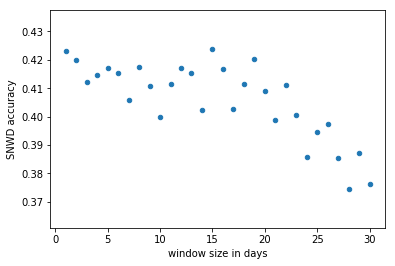

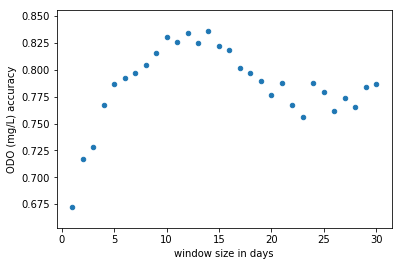

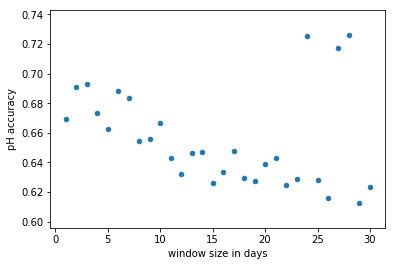

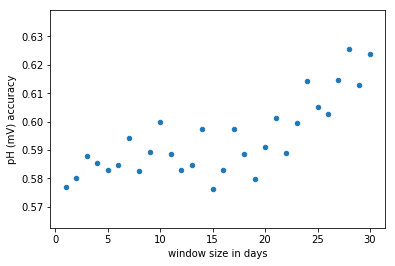

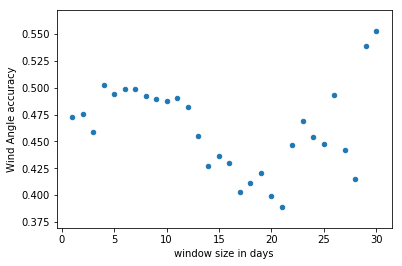

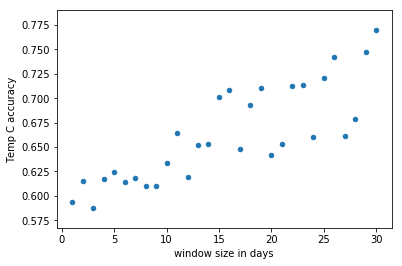

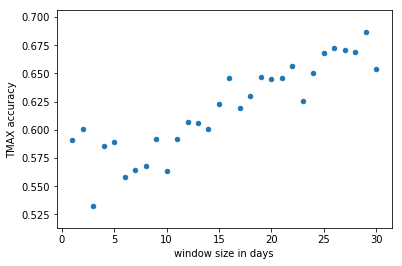

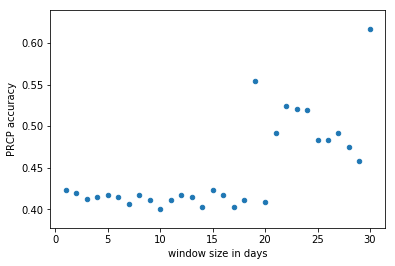

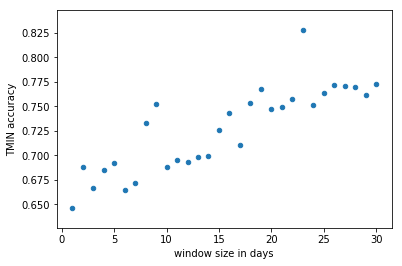

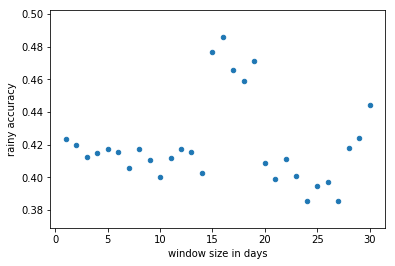

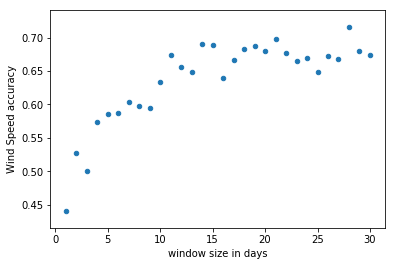

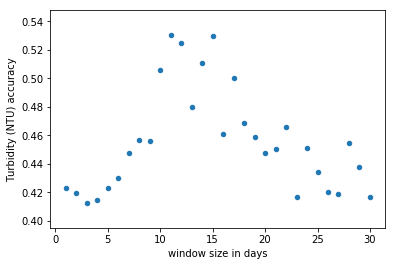

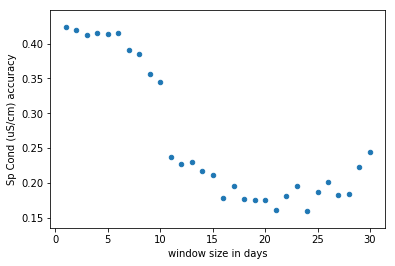

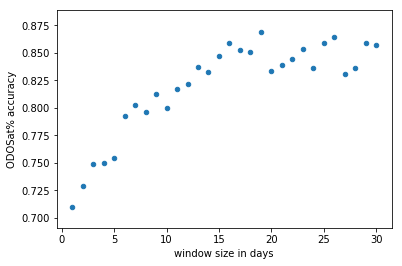

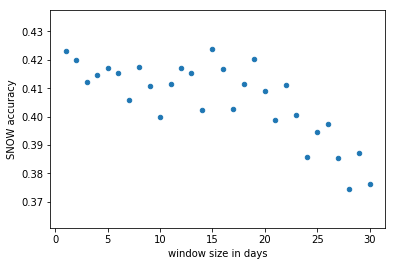

In [90]:
# Plot the accuracies vs window size for each column
sizes = [x.days for x in window_sizes]
for col in x_columns:
    df = pd.DataFrame({col + " accuracy": accuracies[col], 
                           "window size in days": sizes})
    df.plot(kind="scatter", y=col + " accuracy", x="window size in days")

## Greedy Window Size

In [66]:
# add the weather columns to our x_columns
x_columns = list(set(x_columns + 
                     ['PRCP', 'SNOW', 'SNWD', 'TMAX', 'TMIN', 
                      'rainy', 'Wind Speed', 'Wind Angle']))

iteration_delta = pd.Timedelta(1, unit='d')
max_x_window = pd.Timedelta(30, unit='d') 
current_y_window = pd.Timedelta(1, unit='d')
best_accuracy = 0
best_recall = 0
best_precision = 0
best_x_window = iteration_delta
best_y_window = current_y_window

window_sizes = []
accuracies = []

max_iter = 25000
loss = "log"

current_x_window = current_y_window
while current_x_window <= max_x_window:

    # Windowize
    print("current x window", current_x_window)
    print("Windowizing 2017 data set:", train_index)
    train = hf.data_window_reduction(
        train_dfs[train_index], 'datetime', target_column, 
        x_win_size=current_x_window, y_win_size=current_y_window)
    print("Windowizing 2018 data set:", test_index)
    test = hf.data_window_reduction(
        test_dfs[test_index], 'datetime', target_column,
        x_win_size=current_x_window, y_win_size=current_y_window)
    print()

    #Add rainy column
    for df in [test, train]:
        df['rainy'] = df['PRCP'].apply(
            lambda x: 1 if x > 0 else 0).astype('category')

    #Add target columns
    lrf.add_target_column([train, test], threshold=RFU_THRESHOLD)

    # Sort columns by accuracy
    model = SGDClassifier(max_iter=max_iter, loss=loss)
    sorted_columns = lrf.sort_columns_by_metric(model, train, 
                                                test,
                                                x_columns,
                                                'bloom', verbose=0)
    # Create greedy model
    model = SGDClassifier(max_iter=max_iter, loss=loss)
    accuracy, recall, precision, cm, predictions, _, _ = lrf.greedy_model(
        model, train, test, x_columns,'bloom', sorted_columns )
    accuracies.append(accuracy)
    window_sizes.append(current_x_window)
    print("accuracy", accuracy)
    print("recall", recall)
    print("precision", precision)
    print()
    if accuracy > best_accuracy:
        print("Better Accuracy Found")
        best_accuracy = accuracy
        best_recall = recall
        best_precision = precision
        best_x_window = current_x_window
        best_y_window = current_y_window
    current_x_window += iteration_delta

current x window 1 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature windows...
Extracting target windows...
Combining extractions...



C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 

base_columns: []
sorted_columns: ['ODOSat%', 'ODO (mg/L)', 'pH', 'TMIN', 'Temp C', 'TMAX', 'pH (mV)', 'Wind Angle', 'Wind Speed', 'SNWD', 'PRCP', 'rainy', 'Turbidity (NTU)', 'Sp Cond (uS/cm)', 'SNOW']
adjusted sorted_columns: ['ODOSat%', 'ODO (mg/L)', 'pH', 'TMIN', 'Temp C', 'TMAX', 'pH (mV)', 'Wind Angle', 'Wind Speed', 'SNWD', 'PRCP', 'rainy', 'Turbidity (NTU)', 'Sp Cond (uS/cm)', 'SNOW']
Training model with: ['ODOSat%']
Test model accuracy: 0.7101449275362319
Test model recall: 0.6683417085427136
Test model precision: 0.7964071856287425

Updating greedy model

Training model with: ['ODOSat%', 'ODO (mg/L)']
Test model accuracy: 0.7072463768115942
Test model recall: 0.6984924623115578
Test model precision: 0.7722222222222223

Training model with: ['ODOSat%', 'pH']
Test model accuracy: 0.6811594202898551
Test model recall: 0.8793969849246231
Test model precision: 0.6704980842911877

Training model with: ['ODOSat%', 'TMIN']
Test model accuracy: 0.7101449275362319
Test model recall: 0.67

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 

base_columns: []
sorted_columns: ['ODOSat%', 'ODO (mg/L)', 'pH', 'TMIN', 'Temp C', 'TMAX', 'pH (mV)', 'Wind Speed', 'Wind Angle', 'SNWD', 'PRCP', 'rainy', 'Turbidity (NTU)', 'Sp Cond (uS/cm)', 'SNOW']
adjusted sorted_columns: ['ODOSat%', 'ODO (mg/L)', 'pH', 'TMIN', 'Temp C', 'TMAX', 'pH (mV)', 'Wind Speed', 'Wind Angle', 'SNWD', 'PRCP', 'rainy', 'Turbidity (NTU)', 'Sp Cond (uS/cm)', 'SNOW']
Training model with: ['ODOSat%']
Test model accuracy: 0.7288629737609329
Test model recall: 0.7085427135678392
Test model precision: 0.8011363636363636

Updating greedy model

Training model with: ['ODOSat%', 'ODO (mg/L)']
Test model accuracy: 0.7521865889212828
Test model recall: 0.7889447236180904
Test model precision: 0.785

Updating greedy model

Training model with: ['ODOSat%', 'ODO (mg/L)', 'pH']
Test model accuracy: 0.7551020408163265
Test model recall: 0.8944723618090452
Test model precision: 0.7385892116182573

Updating greedy model

Training model with: ['ODOSat%', 'ODO (mg/L)', 'pH', 'TMI

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 

base_columns: []
sorted_columns: ['ODOSat%', 'ODO (mg/L)', 'pH', 'TMIN', 'pH (mV)', 'Temp C', 'TMAX', 'Wind Speed', 'Wind Angle', 'SNWD', 'PRCP', 'rainy', 'Turbidity (NTU)', 'Sp Cond (uS/cm)', 'SNOW']
adjusted sorted_columns: ['ODOSat%', 'ODO (mg/L)', 'pH', 'TMIN', 'pH (mV)', 'Temp C', 'TMAX', 'Wind Speed', 'Wind Angle', 'SNWD', 'PRCP', 'rainy', 'Turbidity (NTU)', 'Sp Cond (uS/cm)', 'SNOW']
Training model with: ['ODOSat%']
Test model accuracy: 0.7485380116959064
Test model recall: 0.7114427860696517
Test model precision: 0.8362573099415205

Updating greedy model

Training model with: ['ODOSat%', 'ODO (mg/L)']
Test model accuracy: 0.7543859649122807
Test model recall: 0.7611940298507462
Test model precision: 0.8095238095238095

Updating greedy model

Training model with: ['ODOSat%', 'ODO (mg/L)', 'pH']
Test model accuracy: 0.7748538011695907
Test model recall: 0.8706467661691543
Test model precision: 0.7743362831858407

Updating greedy model

Training model with: ['ODOSat%', 'ODO (mg/L)

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 

base_columns: []
sorted_columns: ['ODO (mg/L)', 'ODOSat%', 'TMIN', 'pH', 'Temp C', 'pH (mV)', 'TMAX', 'Wind Speed', 'Wind Angle', 'SNWD', 'PRCP', 'rainy', 'Turbidity (NTU)', 'Sp Cond (uS/cm)', 'SNOW']
adjusted sorted_columns: ['ODO (mg/L)', 'ODOSat%', 'TMIN', 'pH', 'Temp C', 'pH (mV)', 'TMAX', 'Wind Speed', 'Wind Angle', 'SNWD', 'PRCP', 'rainy', 'Turbidity (NTU)', 'Sp Cond (uS/cm)', 'SNOW']
Training model with: ['ODO (mg/L)']
Test model accuracy: 0.7676470588235295
Test model recall: 0.7839195979899497
Test model precision: 0.8125

Updating greedy model

Training model with: ['ODO (mg/L)', 'ODOSat%']
Test model accuracy: 0.788235294117647
Test model recall: 0.7738693467336684
Test model precision: 0.850828729281768

Updating greedy model

Training model with: ['ODO (mg/L)', 'ODOSat%', 'TMIN']
Test model accuracy: 0.7911764705882353
Test model recall: 0.7939698492462312
Test model precision: 0.8404255319148937

Updating greedy model

Training model with: ['ODO (mg/L)', 'ODOSat%', 'TMIN'

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 

base_columns: []
sorted_columns: ['ODO (mg/L)', 'ODOSat%', 'TMIN', 'pH', 'Temp C', 'TMAX', 'Wind Speed', 'pH (mV)', 'Wind Angle', 'Turbidity (NTU)', 'SNWD', 'PRCP', 'rainy', 'SNOW', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['ODO (mg/L)', 'ODOSat%', 'TMIN', 'pH', 'Temp C', 'TMAX', 'Wind Speed', 'pH (mV)', 'Wind Angle', 'Turbidity (NTU)', 'SNWD', 'PRCP', 'rainy', 'SNOW', 'Sp Cond (uS/cm)']
Training model with: ['ODO (mg/L)']
Test model accuracy: 0.7869822485207101
Test model recall: 0.817258883248731
Test model precision: 0.817258883248731

Updating greedy model

Training model with: ['ODO (mg/L)', 'ODOSat%']
Test model accuracy: 0.7988165680473372
Test model recall: 0.8071065989847716
Test model precision: 0.8412698412698413

Updating greedy model

Training model with: ['ODO (mg/L)', 'ODOSat%', 'TMIN']
Test model accuracy: 0.7958579881656804
Test model recall: 0.7969543147208121
Test model precision: 0.8440860215053764

Training model with: ['ODO (mg/L)', 'ODOSat%', 'pH']
Test model 

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 

base_columns: []
sorted_columns: ['ODO (mg/L)', 'ODOSat%', 'pH', 'TMIN', 'Temp C', 'Wind Speed', 'pH (mV)', 'TMAX', 'Wind Angle', 'Turbidity (NTU)', 'SNWD', 'PRCP', 'rainy', 'Sp Cond (uS/cm)', 'SNOW']
adjusted sorted_columns: ['ODO (mg/L)', 'ODOSat%', 'pH', 'TMIN', 'Temp C', 'Wind Speed', 'pH (mV)', 'TMAX', 'Wind Angle', 'Turbidity (NTU)', 'SNWD', 'PRCP', 'rainy', 'Sp Cond (uS/cm)', 'SNOW']
Training model with: ['ODO (mg/L)']
Test model accuracy: 0.7922848664688428
Test model recall: 0.8324873096446701
Test model precision: 0.8159203980099502

Updating greedy model

Training model with: ['ODO (mg/L)', 'ODOSat%']
Test model accuracy: 0.7922848664688428
Test model recall: 0.7868020304568528
Test model precision: 0.8469945355191257

Training model with: ['ODO (mg/L)', 'pH']
Test model accuracy: 0.7774480712166172
Test model recall: 0.8984771573604061
Test model precision: 0.7629310344827587

Training model with: ['ODO (mg/L)', 'TMIN']
Test model accuracy: 0.798219584569733
Test model reca

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 

base_columns: []
sorted_columns: ['ODOSat%', 'ODO (mg/L)', 'pH', 'TMIN', 'Temp C', 'Wind Speed', 'pH (mV)', 'TMAX', 'Wind Angle', 'Turbidity (NTU)', 'SNWD', 'PRCP', 'rainy', 'SNOW', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['ODOSat%', 'ODO (mg/L)', 'pH', 'TMIN', 'Temp C', 'Wind Speed', 'pH (mV)', 'TMAX', 'Wind Angle', 'Turbidity (NTU)', 'SNWD', 'PRCP', 'rainy', 'SNOW', 'Sp Cond (uS/cm)']
Training model with: ['ODOSat%']
Test model accuracy: 0.8029850746268656
Test model recall: 0.7587939698492462
Test model precision: 0.893491124260355

Updating greedy model

Training model with: ['ODOSat%', 'ODO (mg/L)']
Test model accuracy: 0.8059701492537313
Test model recall: 0.8140703517587939
Test model precision: 0.8526315789473684

Updating greedy model

Training model with: ['ODOSat%', 'ODO (mg/L)', 'pH']
Test model accuracy: 0.7820895522388059
Test model recall: 0.8341708542713567
Test model precision: 0.8058252427184466

Training model with: ['ODOSat%', 'ODO (mg/L)', 'TMIN']
Test model ac

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 

base_columns: []
sorted_columns: ['ODO (mg/L)', 'ODOSat%', 'TMIN', 'pH', 'Temp C', 'Wind Speed', 'pH (mV)', 'TMAX', 'Wind Angle', 'Turbidity (NTU)', 'SNWD', 'PRCP', 'rainy', 'SNOW', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['ODO (mg/L)', 'ODOSat%', 'TMIN', 'pH', 'Temp C', 'Wind Speed', 'pH (mV)', 'TMAX', 'Wind Angle', 'Turbidity (NTU)', 'SNWD', 'PRCP', 'rainy', 'SNOW', 'Sp Cond (uS/cm)']
Training model with: ['ODO (mg/L)']
Test model accuracy: 0.8048048048048048
Test model recall: 0.8711340206185567
Test model precision: 0.8086124401913876

Updating greedy model

Training model with: ['ODO (mg/L)', 'ODOSat%']
Test model accuracy: 0.7987987987987988
Test model recall: 0.8195876288659794
Test model precision: 0.8324607329842932

Training model with: ['ODO (mg/L)', 'TMIN']
Test model accuracy: 0.8048048048048048
Test model recall: 0.8350515463917526
Test model precision: 0.8307692307692308

Training model with: ['ODO (mg/L)', 'pH']
Test model accuracy: 0.7297297297297297
Test model rec

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 

base_columns: []
sorted_columns: ['ODO (mg/L)', 'ODOSat%', 'TMIN', 'pH', 'Temp C', 'Wind Speed', 'TMAX', 'pH (mV)', 'Wind Angle', 'Turbidity (NTU)', 'SNWD', 'PRCP', 'rainy', 'SNOW', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['ODO (mg/L)', 'ODOSat%', 'TMIN', 'pH', 'Temp C', 'Wind Speed', 'TMAX', 'pH (mV)', 'Wind Angle', 'Turbidity (NTU)', 'SNWD', 'PRCP', 'rainy', 'SNOW', 'Sp Cond (uS/cm)']
Training model with: ['ODO (mg/L)']
Test model accuracy: 0.8157099697885196
Test model recall: 0.882051282051282
Test model precision: 0.819047619047619

Updating greedy model

Training model with: ['ODO (mg/L)', 'ODOSat%']
Test model accuracy: 0.8277945619335347
Test model recall: 0.8769230769230769
Test model precision: 0.8382352941176471

Updating greedy model

Training model with: ['ODO (mg/L)', 'ODOSat%', 'TMIN']
Test model accuracy: 0.8157099697885196
Test model recall: 0.8564102564102564
Test model precision: 0.835

Training model with: ['ODO (mg/L)', 'ODOSat%', 'pH']
Test model accuracy: 0.8

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 

base_columns: []
sorted_columns: ['ODO (mg/L)', 'ODOSat%', 'TMIN', 'pH', 'Temp C', 'Wind Speed', 'pH (mV)', 'TMAX', 'Turbidity (NTU)', 'Wind Angle', 'SNWD', 'PRCP', 'rainy', 'SNOW', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['ODO (mg/L)', 'ODOSat%', 'TMIN', 'pH', 'Temp C', 'Wind Speed', 'pH (mV)', 'TMAX', 'Turbidity (NTU)', 'Wind Angle', 'SNWD', 'PRCP', 'rainy', 'SNOW', 'Sp Cond (uS/cm)']
Training model with: ['ODO (mg/L)']
Test model accuracy: 0.8303030303030303
Test model recall: 0.8838383838383839
Test model precision: 0.8413461538461539

Updating greedy model

Training model with: ['ODO (mg/L)', 'ODOSat%']
Test model accuracy: 0.7787878787878788
Test model recall: 0.7929292929292929
Test model precision: 0.8306878306878307

Training model with: ['ODO (mg/L)', 'TMIN']
Test model accuracy: 0.806060606060606
Test model recall: 0.8232323232323232
Test model precision: 0.8489583333333334

Training model with: ['ODO (mg/L)', 'pH']
Test model accuracy: 0.7818181818181819
Test model reca

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 

base_columns: []
sorted_columns: ['ODO (mg/L)', 'ODOSat%', 'TMIN', 'Wind Speed', 'Temp C', 'pH', 'TMAX', 'pH (mV)', 'Turbidity (NTU)', 'Wind Angle', 'SNWD', 'PRCP', 'rainy', 'SNOW', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['ODO (mg/L)', 'ODOSat%', 'TMIN', 'Wind Speed', 'Temp C', 'pH', 'TMAX', 'pH (mV)', 'Turbidity (NTU)', 'Wind Angle', 'SNWD', 'PRCP', 'rainy', 'SNOW', 'Sp Cond (uS/cm)']
Training model with: ['ODO (mg/L)']
Test model accuracy: 0.8262195121951219
Test model recall: 0.9067357512953368
Test model precision: 0.8177570093457944

Updating greedy model

Training model with: ['ODO (mg/L)', 'ODOSat%']
Test model accuracy: 0.7896341463414634
Test model recall: 0.8290155440414507
Test model precision: 0.8163265306122449

Training model with: ['ODO (mg/L)', 'TMIN']
Test model accuracy: 0.823170731707317
Test model recall: 0.8601036269430051
Test model precision: 0.8426395939086294

Training model with: ['ODO (mg/L)', 'Wind Speed']
Test model accuracy: 0.8323170731707317
Test mo

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 

base_columns: []
sorted_columns: ['ODO (mg/L)', 'ODOSat%', 'TMIN', 'Wind Speed', 'pH', 'Temp C', 'TMAX', 'pH (mV)', 'Turbidity (NTU)', 'Wind Angle', 'SNWD', 'PRCP', 'rainy', 'SNOW', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['ODO (mg/L)', 'ODOSat%', 'TMIN', 'Wind Speed', 'pH', 'Temp C', 'TMAX', 'pH (mV)', 'Turbidity (NTU)', 'Wind Angle', 'SNWD', 'PRCP', 'rainy', 'SNOW', 'Sp Cond (uS/cm)']
Training model with: ['ODO (mg/L)']
Test model accuracy: 0.8343558282208589
Test model recall: 0.8842105263157894
Test model precision: 0.84

Updating greedy model

Training model with: ['ODO (mg/L)', 'ODOSat%']
Test model accuracy: 0.7944785276073619
Test model recall: 0.8368421052631579
Test model precision: 0.8153846153846154

Training model with: ['ODO (mg/L)', 'TMIN']
Test model accuracy: 0.8128834355828221
Test model recall: 0.8631578947368421
Test model precision: 0.8241206030150754

Training model with: ['ODO (mg/L)', 'Wind Speed']
Test model accuracy: 0.8374233128834356
Test model recall: 0

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 

base_columns: []
sorted_columns: ['ODOSat%', 'ODO (mg/L)', 'TMIN', 'Temp C', 'Wind Speed', 'pH', 'TMAX', 'pH (mV)', 'Turbidity (NTU)', 'Wind Angle', 'SNWD', 'PRCP', 'rainy', 'SNOW', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['ODOSat%', 'ODO (mg/L)', 'TMIN', 'Temp C', 'Wind Speed', 'pH', 'TMAX', 'pH (mV)', 'Turbidity (NTU)', 'Wind Angle', 'SNWD', 'PRCP', 'rainy', 'SNOW', 'Sp Cond (uS/cm)']
Training model with: ['ODOSat%']
Test model accuracy: 0.8369230769230769
Test model recall: 0.8157894736842105
Test model precision: 0.8959537572254336

Updating greedy model

Training model with: ['ODOSat%', 'ODO (mg/L)']
Test model accuracy: 0.8215384615384616
Test model recall: 0.8473684210526315
Test model precision: 0.8473684210526315

Training model with: ['ODOSat%', 'TMIN']
Test model accuracy: 0.84
Test model recall: 0.8210526315789474
Test model precision: 0.896551724137931

Updating greedy model

Training model with: ['ODOSat%', 'TMIN', 'Temp C']
Test model accuracy: 0.8461538461538461
Tes

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 

base_columns: []
sorted_columns: ['ODO (mg/L)', 'ODOSat%', 'TMIN', 'Wind Speed', 'Temp C', 'pH', 'TMAX', 'pH (mV)', 'Turbidity (NTU)', 'Wind Angle', 'SNWD', 'PRCP', 'rainy', 'SNOW', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['ODO (mg/L)', 'ODOSat%', 'TMIN', 'Wind Speed', 'Temp C', 'pH', 'TMAX', 'pH (mV)', 'Turbidity (NTU)', 'Wind Angle', 'SNWD', 'PRCP', 'rainy', 'SNOW', 'Sp Cond (uS/cm)']
Training model with: ['ODO (mg/L)']
Test model accuracy: 0.8359133126934984
Test model recall: 0.8860103626943006
Test model precision: 0.8465346534653465

Updating greedy model

Training model with: ['ODO (mg/L)', 'ODOSat%']
Test model accuracy: 0.8173374613003096
Test model recall: 0.844559585492228
Test model precision: 0.8489583333333334

Training model with: ['ODO (mg/L)', 'TMIN']
Test model accuracy: 0.8359133126934984
Test model recall: 0.8134715025906736
Test model precision: 0.9022988505747126

Training model with: ['ODO (mg/L)', 'Wind Speed']
Test model accuracy: 0.8018575851393189
Test mo

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 

base_columns: []
sorted_columns: ['ODOSat%', 'ODO (mg/L)', 'TMIN', 'Temp C', 'Wind Speed', 'pH', 'TMAX', 'pH (mV)', 'Turbidity (NTU)', 'rainy', 'Wind Angle', 'SNWD', 'PRCP', 'SNOW', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['ODOSat%', 'ODO (mg/L)', 'TMIN', 'Temp C', 'Wind Speed', 'pH', 'TMAX', 'pH (mV)', 'Turbidity (NTU)', 'rainy', 'Wind Angle', 'SNWD', 'PRCP', 'SNOW', 'Sp Cond (uS/cm)']
Training model with: ['ODOSat%']
Test model accuracy: 0.8473520249221184
Test model recall: 0.8432432432432433
Test model precision: 0.8863636363636364

Updating greedy model

Training model with: ['ODOSat%', 'ODO (mg/L)']
Test model accuracy: 0.8193146417445483
Test model recall: 0.8702702702702703
Test model precision: 0.8256410256410256

Training model with: ['ODOSat%', 'TMIN']
Test model accuracy: 0.8566978193146417
Test model recall: 0.8540540540540541
Test model precision: 0.8926553672316384

Updating greedy model

Training model with: ['ODOSat%', 'TMIN', 'Temp C']
Test model accuracy: 0.85046

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 

base_columns: []
sorted_columns: ['ODOSat%', 'ODO (mg/L)', 'TMIN', 'Temp C', 'TMAX', 'Wind Speed', 'pH', 'pH (mV)', 'rainy', 'Turbidity (NTU)', 'Wind Angle', 'SNWD', 'PRCP', 'SNOW', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['ODOSat%', 'ODO (mg/L)', 'TMIN', 'Temp C', 'TMAX', 'Wind Speed', 'pH', 'pH (mV)', 'rainy', 'Turbidity (NTU)', 'Wind Angle', 'SNWD', 'PRCP', 'SNOW', 'Sp Cond (uS/cm)']
Training model with: ['ODOSat%']
Test model accuracy: 0.8589341692789969
Test model recall: 0.8548387096774194
Test model precision: 0.8983050847457628

Updating greedy model

Training model with: ['ODOSat%', 'ODO (mg/L)']
Test model accuracy: 0.8275862068965517
Test model recall: 0.8870967741935484
Test model precision: 0.8291457286432161

Training model with: ['ODOSat%', 'TMIN']
Test model accuracy: 0.8714733542319749
Test model recall: 0.8763440860215054
Test model precision: 0.9005524861878453

Updating greedy model

Training model with: ['ODOSat%', 'TMIN', 'Temp C']
Test model accuracy: 0.85579

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 

base_columns: []
sorted_columns: ['ODOSat%', 'ODO (mg/L)', 'TMIN', 'Wind Speed', 'pH', 'Temp C', 'TMAX', 'pH (mV)', 'Turbidity (NTU)', 'rainy', 'SNWD', 'Wind Angle', 'PRCP', 'SNOW', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['ODOSat%', 'ODO (mg/L)', 'TMIN', 'Wind Speed', 'pH', 'Temp C', 'TMAX', 'pH (mV)', 'Turbidity (NTU)', 'rainy', 'SNWD', 'Wind Angle', 'PRCP', 'SNOW', 'Sp Cond (uS/cm)']
Training model with: ['ODOSat%']
Test model accuracy: 0.8522012578616353
Test model recall: 0.8315789473684211
Test model precision: 0.9132947976878613

Updating greedy model

Training model with: ['ODOSat%', 'ODO (mg/L)']
Test model accuracy: 0.8647798742138365
Test model recall: 0.8315789473684211
Test model precision: 0.9349112426035503

Updating greedy model

Training model with: ['ODOSat%', 'ODO (mg/L)', 'TMIN']
Test model accuracy: 0.8553459119496856
Test model recall: 0.8473684210526315
Test model precision: 0.9044943820224719

Training model with: ['ODOSat%', 'ODO (mg/L)', 'Wind Speed']
Test

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 

base_columns: []
sorted_columns: ['ODOSat%', 'ODO (mg/L)', 'TMIN', 'Temp C', 'Wind Speed', 'pH', 'TMAX', 'pH (mV)', 'Turbidity (NTU)', 'rainy', 'SNWD', 'Wind Angle', 'PRCP', 'SNOW', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['ODOSat%', 'ODO (mg/L)', 'TMIN', 'Temp C', 'Wind Speed', 'pH', 'TMAX', 'pH (mV)', 'Turbidity (NTU)', 'rainy', 'SNWD', 'Wind Angle', 'PRCP', 'SNOW', 'Sp Cond (uS/cm)']
Training model with: ['ODOSat%']
Test model accuracy: 0.8512658227848101
Test model recall: 0.8440860215053764
Test model precision: 0.8971428571428571

Updating greedy model

Training model with: ['ODOSat%', 'ODO (mg/L)']
Test model accuracy: 0.8575949367088608
Test model recall: 0.8387096774193549
Test model precision: 0.9122807017543859

Updating greedy model

Training model with: ['ODOSat%', 'ODO (mg/L)', 'TMIN']
Test model accuracy: 0.8449367088607594
Test model recall: 0.8602150537634409
Test model precision: 0.8743169398907104

Training model with: ['ODOSat%', 'ODO (mg/L)', 'Temp C']
Test mod

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


base_columns: []
sorted_columns: ['ODOSat%', 'ODO (mg/L)', 'TMIN', 'Temp C', 'Wind Speed', 'TMAX', 'pH', 'pH (mV)', 'PRCP', 'rainy', 'Turbidity (NTU)', 'SNWD', 'Wind Angle', 'SNOW', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['ODOSat%', 'ODO (mg/L)', 'TMIN', 'Temp C', 'Wind Speed', 'TMAX', 'pH', 'pH (mV)', 'PRCP', 'rainy', 'Turbidity (NTU)', 'SNWD', 'Wind Angle', 'SNOW', 'Sp Cond (uS/cm)']
Training model with: ['ODOSat%']
Test model accuracy: 0.8694267515923567
Test model recall: 0.8736263736263736
Test model precision: 0.8983050847457628

Updating greedy model

Training model with: ['ODOSat%', 'ODO (mg/L)']
Test model accuracy: 0.8662420382165605
Test model recall: 0.8791208791208791
Test model precision: 0.8888888888888888

Training model with: ['ODOSat%', 'TMIN']
Test model accuracy: 0.8726114649681529
Test model recall: 0.8736263736263736
Test model precision: 0.9034090909090909

Updating greedy model

Training model with: ['ODOSat%', 'TMIN', 'Temp C']
Test model accuracy: 0.85668

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 

base_columns: []
sorted_columns: ['ODOSat%', 'ODO (mg/L)', 'TMIN', 'Wind Speed', 'TMAX', 'Temp C', 'pH', 'pH (mV)', 'Turbidity (NTU)', 'SNWD', 'PRCP', 'rainy', 'SNOW', 'Wind Angle', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['ODOSat%', 'ODO (mg/L)', 'TMIN', 'Wind Speed', 'TMAX', 'Temp C', 'pH', 'pH (mV)', 'Turbidity (NTU)', 'SNWD', 'PRCP', 'rainy', 'SNOW', 'Wind Angle', 'Sp Cond (uS/cm)']
Training model with: ['ODOSat%']
Test model accuracy: 0.8338658146964856
Test model recall: 0.7837837837837838
Test model precision: 0.9235668789808917

Updating greedy model

Training model with: ['ODOSat%', 'ODO (mg/L)']
Test model accuracy: 0.865814696485623
Test model recall: 0.8432432432432433
Test model precision: 0.9230769230769231

Updating greedy model

Training model with: ['ODOSat%', 'ODO (mg/L)', 'TMIN']
Test model accuracy: 0.8434504792332268
Test model recall: 0.8432432432432433
Test model precision: 0.8863636363636364

Training model with: ['ODOSat%', 'ODO (mg/L)', 'Wind Speed']
Test 

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 

base_columns: []
sorted_columns: ['ODOSat%', 'ODO (mg/L)', 'TMIN', 'Wind Speed', 'Temp C', 'TMAX', 'pH', 'pH (mV)', 'PRCP', 'Turbidity (NTU)', 'SNWD', 'rainy', 'SNOW', 'Wind Angle', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['ODOSat%', 'ODO (mg/L)', 'TMIN', 'Wind Speed', 'Temp C', 'TMAX', 'pH', 'pH (mV)', 'PRCP', 'Turbidity (NTU)', 'SNWD', 'rainy', 'SNOW', 'Wind Angle', 'Sp Cond (uS/cm)']
Training model with: ['ODOSat%']
Test model accuracy: 0.8392282958199357
Test model recall: 0.786096256684492
Test model precision: 0.9363057324840764

Updating greedy model

Training model with: ['ODOSat%', 'ODO (mg/L)']
Test model accuracy: 0.8681672025723473
Test model recall: 0.839572192513369
Test model precision: 0.9345238095238095

Updating greedy model

Training model with: ['ODOSat%', 'ODO (mg/L)', 'TMIN']
Test model accuracy: 0.8392282958199357
Test model recall: 0.8449197860962567
Test model precision: 0.88268156424581

Training model with: ['ODOSat%', 'ODO (mg/L)', 'Wind Speed']
Test mod

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 

base_columns: []
sorted_columns: ['ODOSat%', 'ODO (mg/L)', 'TMIN', 'Temp C', 'Wind Speed', 'TMAX', 'pH', 'pH (mV)', 'PRCP', 'Turbidity (NTU)', 'Wind Angle', 'SNWD', 'rainy', 'SNOW', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['ODOSat%', 'ODO (mg/L)', 'TMIN', 'Temp C', 'Wind Speed', 'TMAX', 'pH', 'pH (mV)', 'PRCP', 'Turbidity (NTU)', 'Wind Angle', 'SNWD', 'rainy', 'SNOW', 'Sp Cond (uS/cm)']
Training model with: ['ODOSat%']
Test model accuracy: 0.8446601941747572
Test model recall: 0.8076923076923077
Test model precision: 0.91875

Updating greedy model

Training model with: ['ODOSat%', 'ODO (mg/L)']
Test model accuracy: 0.86084142394822
Test model recall: 0.8571428571428571
Test model precision: 0.9017341040462428

Updating greedy model

Training model with: ['ODOSat%', 'ODO (mg/L)', 'TMIN']
Test model accuracy: 0.8317152103559871
Test model recall: 0.8516483516483516
Test model precision: 0.8611111111111112

Training model with: ['ODOSat%', 'ODO (mg/L)', 'Temp C']
Test model accuracy: 

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 

base_columns: []
sorted_columns: ['ODOSat%', 'TMIN', 'ODO (mg/L)', 'Temp C', 'Wind Speed', 'pH', 'TMAX', 'pH (mV)', 'PRCP', 'Wind Angle', 'Turbidity (NTU)', 'SNWD', 'rainy', 'SNOW', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['ODOSat%', 'TMIN', 'ODO (mg/L)', 'Temp C', 'Wind Speed', 'pH', 'TMAX', 'pH (mV)', 'PRCP', 'Wind Angle', 'Turbidity (NTU)', 'SNWD', 'rainy', 'SNOW', 'Sp Cond (uS/cm)']
Training model with: ['ODOSat%']
Test model accuracy: 0.8534201954397395
Test model recall: 0.8206521739130435
Test model precision: 0.9263803680981595

Updating greedy model

Training model with: ['ODOSat%', 'TMIN']
Test model accuracy: 0.8534201954397395
Test model recall: 0.8206521739130435
Test model precision: 0.9263803680981595

Training model with: ['ODOSat%', 'ODO (mg/L)']
Test model accuracy: 0.8534201954397395
Test model recall: 0.8532608695652174
Test model precision: 0.8971428571428571

Training model with: ['ODOSat%', 'Temp C']
Test model accuracy: 0.8534201954397395
Test model recall: 

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 

base_columns: []
sorted_columns: ['ODOSat%', 'ODO (mg/L)', 'TMIN', 'pH', 'Wind Speed', 'Temp C', 'TMAX', 'pH (mV)', 'PRCP', 'Wind Angle', 'Turbidity (NTU)', 'SNWD', 'rainy', 'SNOW', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['ODOSat%', 'ODO (mg/L)', 'TMIN', 'pH', 'Wind Speed', 'Temp C', 'TMAX', 'pH (mV)', 'PRCP', 'Wind Angle', 'Turbidity (NTU)', 'SNWD', 'rainy', 'SNOW', 'Sp Cond (uS/cm)']
Training model with: ['ODOSat%']
Test model accuracy: 0.8366013071895425
Test model recall: 0.7819148936170213
Test model precision: 0.9423076923076923

Updating greedy model

Training model with: ['ODOSat%', 'ODO (mg/L)']
Test model accuracy: 0.8366013071895425
Test model recall: 0.7819148936170213
Test model precision: 0.9423076923076923

Training model with: ['ODOSat%', 'TMIN']
Test model accuracy: 0.8529411764705882
Test model recall: 0.8085106382978723
Test model precision: 0.9440993788819876

Updating greedy model

Training model with: ['ODOSat%', 'TMIN', 'pH']
Test model accuracy: 0.771241830

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 

base_columns: []
sorted_columns: ['ODOSat%', 'ODO (mg/L)', 'TMIN', 'Temp C', 'TMAX', 'Wind Speed', 'pH', 'pH (mV)', 'PRCP', 'Wind Angle', 'Turbidity (NTU)', 'SNWD', 'rainy', 'SNOW', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['ODOSat%', 'ODO (mg/L)', 'TMIN', 'Temp C', 'TMAX', 'Wind Speed', 'pH', 'pH (mV)', 'PRCP', 'Wind Angle', 'Turbidity (NTU)', 'SNWD', 'rainy', 'SNOW', 'Sp Cond (uS/cm)']
Training model with: ['ODOSat%']
Test model accuracy: 0.8585526315789473
Test model recall: 0.8260869565217391
Test model precision: 0.9325153374233128

Updating greedy model

Training model with: ['ODOSat%', 'ODO (mg/L)']
Test model accuracy: 0.8618421052631579
Test model recall: 0.8315217391304348
Test model precision: 0.9329268292682927

Updating greedy model

Training model with: ['ODOSat%', 'ODO (mg/L)', 'TMIN']
Test model accuracy: 0.7828947368421053
Test model recall: 0.8369565217391305
Test model precision: 0.8105263157894737

Training model with: ['ODOSat%', 'ODO (mg/L)', 'Temp C']
Test mod

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 

base_columns: []
sorted_columns: ['ODOSat%', 'TMIN', 'ODO (mg/L)', 'Temp C', 'TMAX', 'Wind Speed', 'pH', 'pH (mV)', 'Wind Angle', 'PRCP', 'Turbidity (NTU)', 'SNWD', 'rainy', 'SNOW', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['ODOSat%', 'TMIN', 'ODO (mg/L)', 'Temp C', 'TMAX', 'Wind Speed', 'pH', 'pH (mV)', 'Wind Angle', 'PRCP', 'Turbidity (NTU)', 'SNWD', 'rainy', 'SNOW', 'Sp Cond (uS/cm)']
Training model with: ['ODOSat%']
Test model accuracy: 0.8642384105960265
Test model recall: 0.8406593406593407
Test model precision: 0.9272727272727272

Updating greedy model

Training model with: ['ODOSat%', 'TMIN']
Test model accuracy: 0.8543046357615894
Test model recall: 0.8516483516483516
Test model precision: 0.9011627906976745

Training model with: ['ODOSat%', 'ODO (mg/L)']
Test model accuracy: 0.8609271523178808
Test model recall: 0.8351648351648352
Test model precision: 0.926829268292683

Training model with: ['ODOSat%', 'Temp C']
Test model accuracy: 0.8642384105960265
Test model recall: 0

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 

base_columns: []
sorted_columns: ['ODOSat%', 'ODO (mg/L)', 'TMIN', 'pH', 'TMAX', 'Wind Speed', 'Temp C', 'pH (mV)', 'PRCP', 'Wind Angle', 'Turbidity (NTU)', 'SNWD', 'rainy', 'SNOW', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['ODOSat%', 'ODO (mg/L)', 'TMIN', 'pH', 'TMAX', 'Wind Speed', 'Temp C', 'pH (mV)', 'PRCP', 'Wind Angle', 'Turbidity (NTU)', 'SNWD', 'rainy', 'SNOW', 'Sp Cond (uS/cm)']
Training model with: ['ODOSat%']
Test model accuracy: 0.8305647840531561
Test model recall: 0.7837837837837838
Test model precision: 0.9294871794871795

Updating greedy model

Training model with: ['ODOSat%', 'ODO (mg/L)']
Test model accuracy: 0.8338870431893688
Test model recall: 0.7891891891891892
Test model precision: 0.9299363057324841

Updating greedy model

Training model with: ['ODOSat%', 'ODO (mg/L)', 'TMIN']
Test model accuracy: 0.8438538205980066
Test model recall: 0.8162162162162162
Test model precision: 0.9207317073170732

Updating greedy model

Training model with: ['ODOSat%', 'ODO (mg/

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


base_columns: []
sorted_columns: ['ODOSat%', 'TMIN', 'ODO (mg/L)', 'pH', 'Wind Speed', 'Temp C', 'TMAX', 'pH (mV)', 'PRCP', 'Turbidity (NTU)', 'rainy', 'Wind Angle', 'SNWD', 'SNOW', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['ODOSat%', 'TMIN', 'ODO (mg/L)', 'pH', 'Wind Speed', 'Temp C', 'TMAX', 'pH (mV)', 'PRCP', 'Turbidity (NTU)', 'rainy', 'Wind Angle', 'SNWD', 'SNOW', 'Sp Cond (uS/cm)']
Training model with: ['ODOSat%']
Test model accuracy: 0.8361204013377926
Test model recall: 0.7914438502673797
Test model precision: 0.9367088607594937

Updating greedy model

Training model with: ['ODOSat%', 'TMIN']
Test model accuracy: 0.8561872909698997
Test model recall: 0.8235294117647058
Test model precision: 0.9390243902439024

Updating greedy model

Training model with: ['ODOSat%', 'TMIN', 'ODO (mg/L)']
Test model accuracy: 0.8361204013377926
Test model recall: 0.8074866310160428
Test model precision: 0.9207317073170732

Training model with: ['ODOSat%', 'TMIN', 'pH']
Test model accuracy: 0.7

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


base_columns: []
sorted_columns: ['ODOSat%', 'ODO (mg/L)', 'TMIN', 'Temp C', 'TMAX', 'Wind Speed', 'pH', 'pH (mV)', 'Wind Angle', 'PRCP', 'Turbidity (NTU)', 'rainy', 'SNWD', 'SNOW', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['ODOSat%', 'ODO (mg/L)', 'TMIN', 'Temp C', 'TMAX', 'Wind Speed', 'pH', 'pH (mV)', 'Wind Angle', 'PRCP', 'Turbidity (NTU)', 'rainy', 'SNWD', 'SNOW', 'Sp Cond (uS/cm)']
Training model with: ['ODOSat%']
Test model accuracy: 0.8585858585858586
Test model recall: 0.8406593406593407
Test model precision: 0.9216867469879518

Updating greedy model

Training model with: ['ODOSat%', 'ODO (mg/L)']
Test model accuracy: 0.8552188552188552
Test model recall: 0.8351648351648352
Test model precision: 0.9212121212121213

Training model with: ['ODOSat%', 'TMIN']
Test model accuracy: 0.8653198653198653
Test model recall: 0.8571428571428571
Test model precision: 0.9176470588235294

Updating greedy model

Training model with: ['ODOSat%', 'TMIN', 'Temp C']
Test model accuracy: 0.81481

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


base_columns: []
sorted_columns: ['ODOSat%', 'TMIN', 'ODO (mg/L)', 'Temp C', 'Wind Speed', 'TMAX', 'pH', 'pH (mV)', 'PRCP', 'Wind Angle', 'rainy', 'Turbidity (NTU)', 'SNWD', 'SNOW', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['ODOSat%', 'TMIN', 'ODO (mg/L)', 'Temp C', 'Wind Speed', 'TMAX', 'pH', 'pH (mV)', 'PRCP', 'Wind Angle', 'rainy', 'Turbidity (NTU)', 'SNWD', 'SNOW', 'Sp Cond (uS/cm)']
Training model with: ['ODOSat%']
Test model accuracy: 0.8576271186440678
Test model recall: 0.8532608695652174
Test model precision: 0.9127906976744186

Updating greedy model

Training model with: ['ODOSat%', 'TMIN']
Test model accuracy: 0.8576271186440678
Test model recall: 0.8532608695652174
Test model precision: 0.9127906976744186

Training model with: ['ODOSat%', 'ODO (mg/L)']
Test model accuracy: 0.864406779661017
Test model recall: 0.8478260869565217
Test model precision: 0.9285714285714286

Updating greedy model

Training model with: ['ODOSat%', 'ODO (mg/L)', 'Temp C']
Test model accuracy: 0.

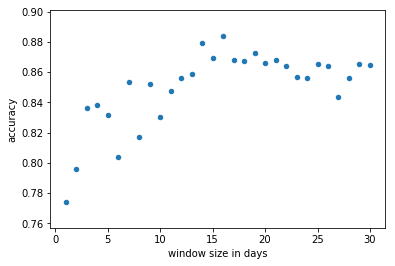

In [78]:
# Plot Accuracy vs window size
df = pd.DataFrame({"accuracy": accuracies, 
                   "window size in days":[x.days for x in window_sizes]})
df.plot(kind="scatter", y="accuracy", x="window size in days")

## Extract Windows

## Add Weather Category

In [25]:
# Add a rainy category
for df in test_dfs + train_dfs:
    df['rainy'] = df['PRCP'].apply(
        lambda x: 1 if x > 0 else 0).astype('category')
test_dfs[test_index].columns

Index(['BGA-Phycocyanin RFU', 'ODO (mg/L)', 'ODOSat%', 'PRCP', 'SNOW', 'SNWD',
       'Sp Cond (uS/cm)', 'TMAX', 'TMIN', 'Temp C', 'Turbidity (NTU)',
       'Wind Angle', 'Wind Speed', 'datetime', 'pH', 'pH (mV)', 'rainy'],
      dtype='object')

In [26]:
# add the weather columns to our x_columns
x_columns = list(set(x_columns + 
                     ['PRCP', 'SNOW', 'SNWD', 'TMAX', 'TMIN', 
                      'rainy', 'Wind Speed', 'Wind Angle']))

In [27]:
lrf.add_target_column(train_dfs + test_dfs, threshold=RFU_THRESHOLD)

## Logistic Regression Model

### Null Model

In [28]:
# The null model's performance
max_iter = 25000
loss = "log"
model = SGDClassifier(max_iter=max_iter, loss=loss)
accuracy, recall, precision, cm, _, _, _ = lrf.train_model(
    model, train_dfs[train_index], test_dfs[test_index], x_columns, 'bloom', True)
print("Accuracy", accuracy)
print("Recall:", recall)
print("Precision", precision)
print("Confusion Matrix:\n", cm)
print("columns:", train_dfs[train_index].columns)

Accuracy 0.40762463343108507
Recall: 0.0
Precision 0.0
Confusion Matrix:
 [[139   0]
 [202   0]]
columns: Index(['BGA-Phycocyanin RFU', 'ODO (mg/L)', 'ODOSat%', 'PRCP', 'SNOW', 'SNWD',
       'Sp Cond (uS/cm)', 'TMAX', 'TMIN', 'Temp C', 'Turbidity (NTU)',
       'Wind Angle', 'Wind Speed', 'datetime', 'pH', 'pH (mV)', 'rainy',
       'bloom'],
      dtype='object')


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


### All variables model

In [29]:
# All variables model performance
max_iter = 25000
loss = "log"
model = SGDClassifier(max_iter=max_iter, loss=loss)
accuracy, recall, precision, cm, _, _, _ = lrf.train_model(
    model, train_dfs[train_index], test_dfs[test_index], x_columns, 'bloom')
print("Accuracy", accuracy)
print("Recall:", recall)
print("Precision", precision)
print("Confusion Matrix:\n", cm)
print("columns:", x_columns)

Accuracy 0.7771260997067448
Recall: 0.7277227722772277
Precision 0.875
Confusion Matrix:
 [[118  21]
 [ 55 147]]
columns: ['SNWD', 'ODO (mg/L)', 'pH', 'pH (mV)', 'Wind Angle', 'Temp C', 'TMAX', 'PRCP', 'TMIN', 'rainy', 'Wind Speed', 'Turbidity (NTU)', 'Sp Cond (uS/cm)', 'ODOSat%', 'SNOW']


### Greedy Model

In [30]:
max_iter = 25000
loss = "log"
model = SGDClassifier(max_iter=max_iter, loss=loss)
# Sort columns by accuracy
sorted_columns = lrf.sort_columns_by_metric(model, train_dfs[train_index], 
                                            test_dfs[test_index],
                                            x_columns,
                                            'bloom')

Training model with: SNWD


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Accuracy 0.40762463343108507
Recall: 0.0
Precision 0.0
Confusion Matrix:
 [[139   0]
 [202   0]]

Training model with: ODO (mg/L)
Accuracy 0.7565982404692082
Recall: 0.7524752475247525
Precision 0.8216216216216217
Confusion Matrix:
 [[106  33]
 [ 50 152]]

Training model with: pH
Accuracy 0.6832844574780058
Recall: 0.9158415841584159
Precision 0.6702898550724637
Confusion Matrix:
 [[ 48  91]
 [ 17 185]]

Training model with: pH (mV)
Accuracy 0.592375366568915
Recall: 1.0
Precision 0.592375366568915
Confusion Matrix:
 [[  0 139]
 [  0 202]]

Training model with: Wind Angle
Accuracy 0.49853372434017595
Recall: 0.24257425742574257
Precision 0.7313432835820896
Confusion Matrix:
 [[121  18]
 [153  49]]

Training model with: Temp C
Accuracy 0.5835777126099707
Recall: 0.37623762376237624
Precision 0.8260869565217391
Confusion Matrix:
 [[123  16]
 [126  76]]

Training model with: TMAX
Accuracy 0.530791788856305
Recall: 0.42574257425742573
Precision 0.6615384615384615
Confusion Matrix:
 [[ 95  

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Accuracy 0.40762463343108507
Recall: 0.0
Precision 0.0
Confusion Matrix:
 [[139   0]
 [202   0]]

Training model with: TMIN
Accuracy 0.6803519061583577
Recall: 0.5693069306930693
Precision 0.8394160583941606
Confusion Matrix:
 [[117  22]
 [ 87 115]]

Training model with: rainy


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Accuracy 0.40762463343108507
Recall: 0.0
Precision 0.0
Confusion Matrix:
 [[139   0]
 [202   0]]

Training model with: Wind Speed
Accuracy 0.5366568914956011
Recall: 0.32673267326732675
Precision 0.75
Confusion Matrix:
 [[117  22]
 [136  66]]

Training model with: Turbidity (NTU)


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Accuracy 0.40762463343108507
Recall: 0.0
Precision 0.0
Confusion Matrix:
 [[139   0]
 [202   0]]

Training model with: Sp Cond (uS/cm)


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Accuracy 0.40762463343108507
Recall: 0.0
Precision 0.0
Confusion Matrix:
 [[139   0]
 [202   0]]

Training model with: ODOSat%
Accuracy 0.7390029325513197
Recall: 0.7029702970297029
Precision 0.8304093567251462
Confusion Matrix:
 [[110  29]
 [ 60 142]]

Training model with: SNOW
Accuracy 0.40762463343108507
Recall: 0.0
Precision 0.0
Confusion Matrix:
 [[139   0]
 [202   0]]

ODO (mg/L) metric value: 0.7565982404692082
ODOSat% metric value: 0.7390029325513197
pH metric value: 0.6832844574780058
TMIN metric value: 0.6803519061583577
pH (mV) metric value: 0.592375366568915
Temp C metric value: 0.5835777126099707
Wind Speed metric value: 0.5366568914956011
TMAX metric value: 0.530791788856305
Wind Angle metric value: 0.49853372434017595
SNWD metric value: 0.40762463343108507
PRCP metric value: 0.40762463343108507
rainy metric value: 0.40762463343108507
Turbidity (NTU) metric value: 0.40762463343108507
Sp Cond (uS/cm) metric value: 0.40762463343108507
SNOW metric value: 0.40762463343108507


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [31]:
#create greedy model
model = SGDClassifier(max_iter=max_iter, loss=loss)

accuracy, recall, precision, cm, predictions, predictions_prob, model = lrf.greedy_model(
    model, train_dfs[train_index], test_dfs[test_index], x_columns, 
                                            'bloom', sorted_columns)


C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


base_columns: []
sorted_columns: ['ODO (mg/L)', 'ODOSat%', 'pH', 'TMIN', 'pH (mV)', 'Temp C', 'Wind Speed', 'TMAX', 'Wind Angle', 'SNWD', 'PRCP', 'rainy', 'Turbidity (NTU)', 'Sp Cond (uS/cm)', 'SNOW']
adjusted sorted_columns: ['ODO (mg/L)', 'ODOSat%', 'pH', 'TMIN', 'pH (mV)', 'Temp C', 'Wind Speed', 'TMAX', 'Wind Angle', 'SNWD', 'PRCP', 'rainy', 'Turbidity (NTU)', 'Sp Cond (uS/cm)', 'SNOW']
Training model with: ['ODO (mg/L)']
Test model accuracy: 0.7565982404692082
Test model recall: 0.7524752475247525
Test model precision: 0.8216216216216217

Updating greedy model

Training model with: ['ODO (mg/L)', 'ODOSat%']
Test model accuracy: 0.7565982404692082
Test model recall: 0.7376237623762376
Test model precision: 0.8324022346368715

Training model with: ['ODO (mg/L)', 'pH']
Test model accuracy: 0.7595307917888563
Test model recall: 0.9158415841584159
Test model precision: 0.74

Updating greedy model

Training model with: ['ODO (mg/L)', 'pH', 'TMIN']
Test model accuracy: 0.7947214076246334

Model AUC: 0.8848


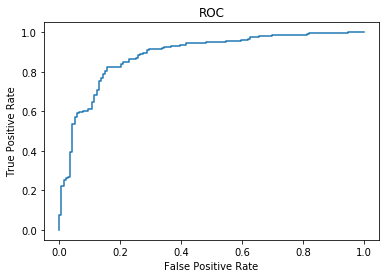

In [32]:
# Print the ROC curve.
predictions = [x[1] for x in predictions_prob]
lrf.roc_plot(test_dfs[test_index][['bloom']].values, predictions)

## Cross validate

In [39]:
base_columns = ['ODO (mg/L)', 'pH', 'TMIN', 'Temp C', 'Wind Speed', 
                'Sp Cond (uS/cm)']
max_iter = 25000
loss = "log"
for i in range(len(train_dfs)):
    print("training on:", train_files[i])
    accuracies = 0
    recalls = 0
    precisions = 0
    for j in range(len(test_dfs)):
        print("testing on:", test_files[j])
        model = SGDClassifier(max_iter=max_iter, loss=loss)
        accuracy, recall, precision, cm, _, _, _ = lrf.train_model(
            model, train_dfs[i], test_dfs[j], base_columns, 'bloom')
        accuracies += accuracy
        recalls += recall
        precisions += precision
        print("Accuracy", accuracy)
        print("Recall:", recall)
        print("Precision", precision)
        print("Confusion Matrix:\n", cm)
    print("Average accuracy:", accuracies/len(test_dfs))
    print("Average recall:", recalls/len(test_dfs))
    print("Average precision:", precisions/len(test_dfs))
    
for i in range(len(train_dfs)):
    print("training on:", test_files[i])
    accuracies = 0
    recalls = 0
    precisions = 0
    for j in range(len(test_dfs)):
        print("testing on:", train_files[j])
        model = SGDClassifier(max_iter=max_iter, loss=loss)
        accuracy, recall, precision, cm, _, _, _ = lrf.train_model(
            model, test_dfs[i], train_dfs[j], base_columns, 'bloom')
        accuracies += accuracy
        recalls += recall
        precisions += precision
        print("Accuracy", accuracy)
        print("Recall:", recall)
        print("Precision", precision)
        print("Confusion Matrix:\n", cm)
    print("Average accuracy:", accuracies/len(test_dfs))
    print("Average recall:", recalls/len(test_dfs))
    print("Average precision:\n", precisions/len(test_dfs))

training on: ../../data/cleaned/utah_2017_vineyard.csv
testing on: ../../data/cleaned/utah_2018_marina.csv
Accuracy 0.8181818181818182
Recall: 0.8712871287128713
Precision 0.8301886792452831
Confusion Matrix:
 [[103  36]
 [ 26 176]]
testing on: ../../data/cleaned/utah_2018_bird.csv
Accuracy 0.7653958944281525
Recall: 0.6604651162790698
Precision 0.9530201342281879
Confusion Matrix:
 [[119   7]
 [ 73 142]]
Average accuracy: 0.7917888563049853
Average recall: 0.7658761224959705
Average precision: 0.8916044067367355
training on: ../../data/cleaned/utah_2017_marina.csv
testing on: ../../data/cleaned/utah_2018_marina.csv
Accuracy 0.7419354838709677
Recall: 0.8910891089108911
Precision 0.7317073170731707
Confusion Matrix:
 [[ 73  66]
 [ 22 180]]
testing on: ../../data/cleaned/utah_2018_bird.csv
Accuracy 0.7712609970674487
Recall: 0.6837209302325581
Precision 0.9363057324840764
Confusion Matrix:
 [[116  10]
 [ 68 147]]
Average accuracy: 0.7565982404692082
Average recall: 0.7874050195717246
Av

## Random Forest Model

In [33]:
# All Inputs
model = RandomForestClassifier(n_estimators=100)
accuracy, recall, precision, cm, predictions, predictions_prob, model = lrf.train_model(
    model, train_dfs[train_index], test_dfs[test_index], x_columns, 'bloom')
print("Accuracy", accuracy)
print("Recall:", recall)
print("Precision", precision)
print("Confusion Matrix:\n", cm)

Accuracy 0.7214076246334311
Recall: 0.8910891089108911
Precision 0.7114624505928854
Confusion Matrix:
 [[ 66  73]
 [ 22 180]]


In [34]:
# Greedy Model
model = RandomForestClassifier(n_estimators=100)
accuracy, recall, precision, cm, predictions, predictions_prob, model = lrf.greedy_model(
    model, train_dfs[train_index], test_dfs[test_index], x_columns, 'bloom', sorted_columns)

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


base_columns: []
sorted_columns: ['ODO (mg/L)', 'ODOSat%', 'pH', 'TMIN', 'pH (mV)', 'Temp C', 'Wind Speed', 'TMAX', 'Wind Angle', 'SNWD', 'PRCP', 'rainy', 'Turbidity (NTU)', 'Sp Cond (uS/cm)', 'SNOW']
adjusted sorted_columns: ['ODO (mg/L)', 'ODOSat%', 'pH', 'TMIN', 'pH (mV)', 'Temp C', 'Wind Speed', 'TMAX', 'Wind Angle', 'SNWD', 'PRCP', 'rainy', 'Turbidity (NTU)', 'Sp Cond (uS/cm)', 'SNOW']
Training model with: ['ODO (mg/L)']
Test model accuracy: 0.7155425219941349
Test model recall: 0.7722772277227723
Test model precision: 0.7536231884057971

Updating greedy model

Training model with: ['ODO (mg/L)', 'ODOSat%']
Test model accuracy: 0.7272727272727273
Test model recall: 0.8366336633663366
Test model precision: 0.7379912663755459

Updating greedy model

Training model with: ['ODO (mg/L)', 'ODOSat%', 'pH']
Test model accuracy: 0.7360703812316716
Test model recall: 0.900990099009901
Test model precision: 0.7222222222222222

Updating greedy model

Training model with: ['ODO (mg/L)', 'ODOSa

Model AUC: 0.8226


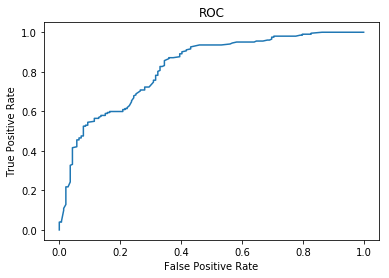

In [35]:
# Print the ROC curve.
predictions = [x[1] for x in predictions_prob]
lrf.roc_plot(test_dfs[test_index][['bloom']].values, predictions)